# Preparation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, mode
import numpy as np

In [62]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

sns.set_theme(style='white', font_scale=1.2)
TIP_colors =  ["#1B4355", "#CB7A2C", "#7A8F50"]
sns.set_palette(TIP_colors)

# HTML("<div style='column-count: 2;'>{}</div>".format(code))
sns.color_palette(TIP_colors)

[(0.10588235294117647, 0.2627450980392157, 0.3333333333333333),
 (0.796078431372549, 0.47843137254901963, 0.17254901960784313),
 (0.47843137254901963, 0.5607843137254902, 0.3137254901960784)]

## Data Cleaning of TIP_StudentData and Demographic Descriptive Analysis

In [33]:
df_student = pd.read_csv(r'C:\Users\sarah\Documents\CMU\Spring 2026\Systems Synthesis\Data\Pre-Cleaning\TIP_StudentData.csv', parse_dates=['DOB', 'GraduatedDate', 'InterviewedDate','StartDate','EndDate'])
df_race = pd.read_csv(r'C:\Users\sarah\Documents\CMU\Spring 2026\Systems Synthesis\Data\Post-Cleaning\tip_demos_rg.csv')[['tip_id', 'census_tract', 'gender', 'race']]

In [34]:
# define status
def status(row):
    if not pd.isnull(row['GraduatedDate']):
        return 'Graduated'
    elif (not pd.isnull(row['StartDate'])) & (not pd.isnull(row['EndDate'])) & ((row['EndDate'] - row['StartDate']).days < 78):
        return 'Non Graduated'
    elif (not pd.isnull(row['InterviewedDate'])) & ((pd.isnull(row['EndDate'])) or (row['EndDate'] - row['InterviewedDate']).days < 78):
        return 'Interviewed'
    else:
        return 'None'
    
df_student['Status'] = df_student.apply(status, axis=1)

In [35]:
# ensure datetime
for c in ["DOB", "StartDate", "InterviewedDate"]:
    if c in df_student.columns:
        df_student[c] = pd.to_datetime(df_student[c], errors="coerce")

# calculate age based on status
age_from_start = (df_student["StartDate"] - df_student["DOB"]).dt.days / 365.25
age_from_interview = (df_student["InterviewedDate"] - df_student["DOB"]).dt.days / 365.25

df_student["age"] = np.select(
    [
        df_student["Status"].isin(["Graduated", "Non Graduated"]),
        df_student["Status"].eq("Interviewed"),
    ],
    [
        np.floor(age_from_start),
        np.floor(age_from_interview),
    ],
    default=np.nan
)

# pre/post 2022 cohort based on StartDate
cutoff = pd.Timestamp("2022-01-01")
df_student["cohort_2022"] = np.where(
    df_student["StartDate"].notna(),
    np.where(df_student["StartDate"] >= cutoff, 2, 1),
    "N/A"
)

# start year
df_student["StartYear"] = df_student["StartDate"].dt.year

# drop DOB
df_student = df_student.drop(columns=["DOB"], errors="ignore")

In [36]:
df_not_none = df_student[df_student['Status'] != 'None'].copy()

In [37]:
df = pd.merge(
    df_not_none,
    df_race,
    on='tip_id',
    how='left'
)

In [38]:
df['Status'].value_counts()

Status
Graduated        759
Non Graduated    703
Interviewed      550
Name: count, dtype: int64

In [48]:
#for post 2022 cohort

df_student['cohort_2022'] = pd.to_numeric(df_student['cohort_2022'], errors='coerce')
df_student.loc[df_student['cohort_2022'] == 2, 'Status'].value_counts()


Status
Graduated        258
Non Graduated    232
Interviewed       37
None              12
Name: count, dtype: int64

In [49]:
#for pre 2022 cohort
df_student.loc[df_student['cohort_2022'] == 1, 'Status'].value_counts()

Status
Graduated        501
Non Graduated    471
None              57
Interviewed       14
Name: count, dtype: int64

In [50]:
df['StartYear'] = df.apply(lambda x: int(x['StartDate'].year) if not pd.isnull(x['StartDate']) else int(x['InterviewedDate'].year), axis=1)

In [53]:
df_grad = df[df["Status"] == "Graduated"].copy()
df_non_grad = df[df["Status"] == "Non Graduated"].copy()

cols_to_check = ["gender", "race"]

for name, target_df in [("Graduated", df_grad), ("Non Graduated", df_non_grad)]:
    print("\n" + "=" * 30)
    print(f"{name}: ")
    print("=" * 30)

    # --- gender/race distribution (drop NaN) ---
    for col in cols_to_check:
        print(f"\n--- {col} (NaN dropped) ---")
        s = target_df[col].dropna()  # drop NaN for both counts + percentages

        counts = s.value_counts()
        percent = s.value_counts(normalize=True) * 100

        dist_df = pd.DataFrame({"Count": counts, "Percentage (%)": percent.round(2)})
        print(dist_df)

    # --- age stats (mean/median) ---
    print("\n--- age stats (mean/median, NaN dropped) ---")
    age_s = pd.to_numeric(target_df["age"], errors="coerce").dropna()
    age_stats = pd.Series(
        {
            "N (non-missing)": int(age_s.shape[0]),
            "Mean": round(age_s.mean(), 2) if age_s.shape[0] else np.nan,
            "Median": round(age_s.median(), 2) if age_s.shape[0] else np.nan,
        }
    )
    print(age_stats)


Graduated: 

--- gender (NaN dropped) ---
        Count  Percentage (%)
gender                       
Male      661           90.18
Female     72            9.82

--- race (NaN dropped) ---
       Count  Percentage (%)
race                        
Black    651           89.67
White     73           10.06
Other      2            0.28

--- age stats (mean/median, NaN dropped) ---
N (non-missing)    759.00
Mean                28.33
Median              27.00
dtype: float64

Non Graduated: 

--- gender (NaN dropped) ---
        Count  Percentage (%)
gender                       
Male      607           90.87
Female     61            9.13

--- race (NaN dropped) ---
       Count  Percentage (%)
race                        
Black    614           92.19
White     50            7.51
Other      2            0.30

--- age stats (mean/median, NaN dropped) ---
N (non-missing)    703.00
Mean                26.69
Median              25.00
dtype: float64


In [57]:
#Split demographic analysis by cohort instead

# Ensure cohort_2022 is numeric
df['cohort_2022'] = pd.to_numeric(df['cohort_2022'], errors='coerce')

# Columns to analyze
cols_to_check = ["gender", "race"]

# Cohorts to analyze
cohorts = [1, 2]

# Filter statuses to include only Participant or Graduated
valid_statuses = ["Non Graduated", "Graduated"]

for cohort_num in cohorts:
    # Apply both filters: cohort AND status
    target_df = df[
        (df["cohort_2022"] == cohort_num) & 
        (df["Status"].isin(valid_statuses))
    ].copy()
    
    print("\n" + "=" * 30)
    print(f"Cohort {cohort_num}: ")
    print("=" * 30)

    if target_df.empty:
        print("No rows for this cohort and status filter!")
        continue

    # --- gender/race distribution (drop NaN) ---
    for col in cols_to_check:
        print(f"\n--- {col} (NaN dropped) ---")
        s = target_df[col].dropna()  # drop NaN for counts + percentages

        counts = s.value_counts()
        percent = s.value_counts(normalize=True) * 100

        dist_df = pd.DataFrame({"Count": counts, "Percentage (%)": percent.round(2)})
        print(dist_df)

    # --- age stats (mean/median) ---
    print("\n--- age stats (mean/median, NaN dropped) ---")
    age_s = pd.to_numeric(target_df["age"], errors='coerce').dropna()
    age_stats = pd.Series(
        {
            "N (non-missing)": int(age_s.shape[0]),
            "Mean": round(age_s.mean(), 2) if age_s.shape[0] else np.nan,
            "Median": round(age_s.median(), 2) if age_s.shape[0] else np.nan,
        }
    )
    print(age_stats)



Cohort 1: 

--- gender (NaN dropped) ---
        Count  Percentage (%)
gender                       
Male      872           93.76
Female     58            6.24

--- race (NaN dropped) ---
       Count  Percentage (%)
race                        
Black    821           88.66
White    103           11.12
Other      2            0.22

--- age stats (mean/median, NaN dropped) ---
N (non-missing)    972.00
Mean                28.15
Median              27.00
dtype: float64

Cohort 2: 

--- gender (NaN dropped) ---
        Count  Percentage (%)
gender                       
Male      396           84.08
Female     75           15.92

--- race (NaN dropped) ---
       Count  Percentage (%)
race                        
Black    444           95.28
White     20            4.29
Other      2            0.43

--- age stats (mean/median, NaN dropped) ---
N (non-missing)    490.00
Mean                26.34
Median              24.00
dtype: float64


In [58]:
#by cohort and by participant type

# Columns to analyze
cols_to_check = ["gender", "race"]

# Cohorts and statuses to include
cohorts = sorted(df['cohort_2022'].dropna().unique())
statuses = ["Graduated", "Non Graduated"]

for cohort_num in cohorts:
    cohort_df = df[df['cohort_2022'] == cohort_num].copy()
    print("\n" + "=" * 50)
    print(f"Cohort {int(cohort_num)}")
    print("=" * 50)

    for status in statuses:
        target_df = cohort_df[cohort_df['Status'] == status].copy()
        if target_df.empty:
            continue

        print("\n" + "-" * 30)
        print(f"Status: {status}")
        print("-" * 30)

        # --- gender/race distribution ---
        for col in cols_to_check:
            print(f"\n--- {col} (NaN dropped) ---")
            s = target_df[col].dropna()
            counts = s.value_counts()
            percent = s.value_counts(normalize=True) * 100
            dist_df = pd.DataFrame({"Count": counts, "Percentage (%)": percent.round(2)})
            print(dist_df)

        # --- age stats ---
        print("\n--- age stats (mean/median, NaN dropped) ---")
        age_s = pd.to_numeric(target_df['age'], errors='coerce').dropna()
        age_stats = pd.Series({
            "N (non-missing)": int(age_s.shape[0]),
            "Mean": round(age_s.mean(), 2) if age_s.shape[0] else np.nan,
            "Median": round(age_s.median(), 2) if age_s.shape[0] else np.nan,
        })
        print(age_stats)


Cohort 1

------------------------------
Status: Graduated
------------------------------

--- gender (NaN dropped) ---
        Count  Percentage (%)
gender                       
Male      460           95.24
Female     23            4.76

--- race (NaN dropped) ---
       Count  Percentage (%)
race                        
Black    418           87.08
White     61           12.71
Other      1            0.21

--- age stats (mean/median, NaN dropped) ---
N (non-missing)    501.00
Mean                29.06
Median              28.00
dtype: float64

------------------------------
Status: Non Graduated
------------------------------

--- gender (NaN dropped) ---
        Count  Percentage (%)
gender                       
Male      412           92.17
Female     35            7.83

--- race (NaN dropped) ---
       Count  Percentage (%)
race                        
Black    403           90.36
White     42            9.42
Other      1            0.22

--- age stats (mean/median, NaN droppe

In [90]:
max_date = '2026-02-14'

def valid_years(row):
    if not pd.isnull(row['GraduatedDate']):
        return (pd.to_datetime(max_date) - row['GraduatedDate']).days / 365.25
    elif not pd.isnull(row['EndDate']):
        return (pd.to_datetime(max_date) - row['EndDate']).days / 365.25
    elif not pd.isnull(row['StartDate']):
        return (pd.to_datetime(max_date) - row['StartDate']).days / 365.25
    elif not pd.isnull(row['InterviewedDate']):
        return (pd.to_datetime(max_date) - row['InterviewedDate']).days / 365.25
    else:
        return None

df['ValidYears'] = df.apply(valid_years, axis=1)
df.sample(10)

,tip_id,GraduatedDate,InterviewedDate,StartDate,EndDate,DriversLicense,Course,CreatedDate,Status,age,cohort_2022,StartYear,census_tract,gender,race,ValidYears
484,612,2017-10-02,NaT,2017-09-11,2017-10-02,No,Introduction to Masonry,2018-07-12,Graduated,37.0,1.0,2017,4.200327e+10,Male,Black,8.369610
1592,1880,NaT,2023-09-27,2023-10-02,2023-10-06,No,Introduction to Masonry,2023-09-27,Non Graduated,20.0,2.0,2023,4.200313e+10,Male,Black,2.360027
1579,1866,NaT,2023-08-31,NaT,NaT,No,Introduction to Masonry,2023-08-31,Interviewed,18.0,NaN,2023,4.200342e+10,Male,Black,2.458590
1433,1719,2023-06-15,2023-03-01,2023-03-06,2023-06-15,No,Carpentry,2023-03-01,Graduated,22.0,2.0,2023,4.200348e+10,Male,Black,2.669405
1175,1459,2022-04-22,2022-02-03,2022-02-07,2022-04-22,Yes,Introduction to Masonry,2022-02-03,Graduated,35.0,2.0,2022,4.200352e+10,Male,Black,3.816564
501,646,2018-01-12,NaT,2017-10-30,2018-01-12,Yes,Introduction to Masonry,2018-07-12,Graduated,25.0,1.0,2017,4.200319e+10,Male,Black,8.090349
627,845,2019-02-08,NaT,2018-11-26,2019-02-08,NaN,Introduction to Masonry,2018-11-15,Graduated,27.0,1.0,2018,4.200327e+10,Male,Black,7.017112
1285,1571,NaT,2022-07-14,NaT,NaT,No,Introduction to Masonry,2022-07-14,Interviewed,18.0,NaN,2022,4.200350e+10,Male,White,3.589322
1325,1611,NaT,2022-09-15,2024-02-12,2024-04-12,Yes,Carpentry,2022-09-15,Non Graduated,20.0,2.0,2024,4.200352e+10,Male,Black,1.842574
589,781,2018-10-19,NaT,2018-08-06,2018-10-19,NaN,Introduction to Masonry,2018-08-01,Graduated,43.0,1.0,2018,4.200312e+10,Male,Black,7.323751


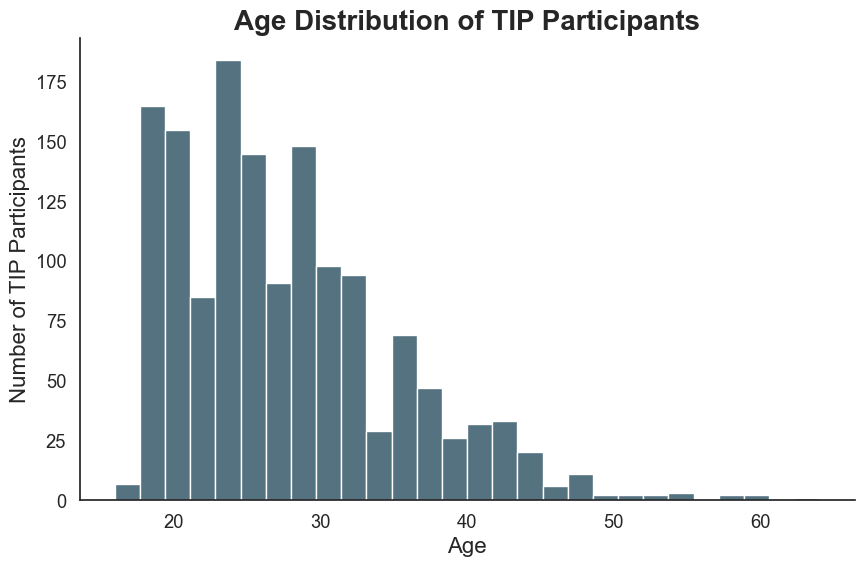

In [14]:
curr_df = df[(df['Status'] == 'Graduated') | (df['Status'] == 'Non Graduated')]
ages = curr_df['age'].dropna()
ages = ages[ages > 5]
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(ages)
sns.despine()
plt.title('Age Distribution of TIP Participants', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Age', fontdict={'fontsize': 16})
plt.ylabel('Number of TIP Participants', fontdict={'fontsize': 16})
plt.show()

C:\Users\sarah\AppData\Local\Temp\ipykernel_31296\2630615500.py:21: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(
C:\Users\sarah\AppData\Local\Temp\ipykernel_31296\2630615500.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cohort')


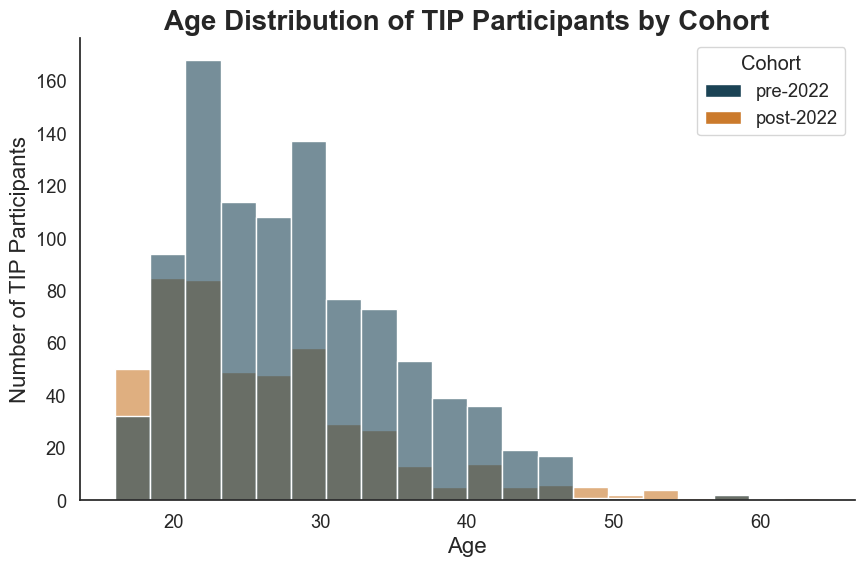

In [70]:
#by cohort

curr_df = df[(df['Status'] == 'Graduated') | (df['Status'] == 'Non Graduated')]
ages = curr_df['age'].dropna()
curr_df = curr_df[curr_df['age'] > 5]  

# Ensure cohort is numeric
curr_df['cohort_2022'] = pd.to_numeric(curr_df['cohort_2022'], errors='coerce')

#cohort label mapping
cohort_label_map = {
    1.0: "pre-2022",
    2.0: "post-2022"
}

cohorts = sorted(curr_df['cohort_2022'].unique())
palette = TIP_colors[:len(cohorts)]

# Plot histogram with overlayed cohorts
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=curr_df,
    x='age',
    hue='cohort_2022',       
    multiple='layer',        
    palette=TIP_colors,          
    bins=20,                 
    alpha=0.6                
)

sns.despine()
plt.title('Age Distribution of TIP Participants by Cohort', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Age', fontdict={'fontsize': 16})
plt.ylabel('Number of TIP Participants', fontdict={'fontsize': 16})
plt.legend(title='Cohort')
from matplotlib.patches import Patch
handles = [Patch(facecolor=palette[i], label=cohort_label_map[cohorts[i]]) 
           for i in range(len(cohorts))]

plt.legend(handles=handles, title='Cohort', loc='upper right')

ax.legend(handles=handles, title='Cohort', loc='upper right')
plt.show()

In [15]:
ages.describe()

count    1459.000000
mean       27.600411
std         7.447026
min        16.000000
25%        22.000000
50%        26.000000
75%        32.000000
max        64.000000
Name: age, dtype: float64

In [16]:
df['Status'].value_counts()

Status
Graduated        759
Non Graduated    703
Interviewed      550
Name: count, dtype: int64

C:\Users\sarah\AppData\Local\Temp\ipykernel_31296\3716141299.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  graph_counts = df.groupby(['StartYear', 'Status']).size().unstack(fill_value=0)


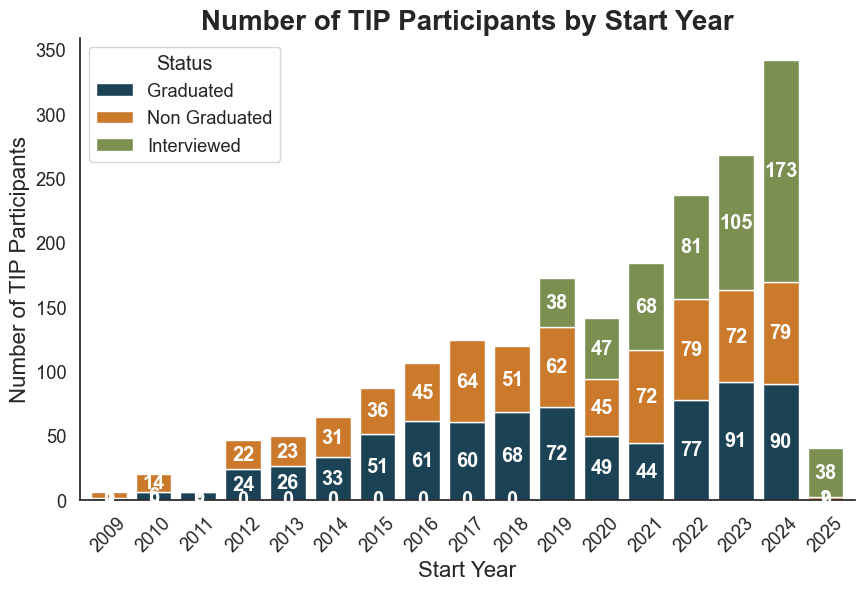

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

status_order = ["Graduated", "Non Graduated", "Interviewed"]
df['Status'] = pd.Categorical(df['Status'], categories=status_order, ordered=True)

graph_counts = df.groupby(['StartYear', 'Status']).size().unstack(fill_value=0) 
graph_counts.plot(kind='bar', stacked=True, ax=ax, width=0.8)

for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fontweight='bold')

sns.despine()
plt.xticks(rotation=45)
plt.title('Number of TIP Participants by Start Year', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Start Year', fontdict={'fontsize': 16})
plt.ylabel('Number of TIP Participants', fontdict={'fontsize': 16})
plt.show()

## Data Cleaning of TIP_MergedSentencingData and Offense Descriptive Analysis

In [161]:
df_convictions = pd.read_csv(r'C:\Users\sarah\Documents\CMU\Spring 2026\Systems Synthesis\Data\Pre-Cleaning\TIP_MergedSentencingData.csv', parse_dates=['DOF', 'DOS', 'StartDate', 'InterviewedDate', 'EndDate', 'GraduatedDate'])
df_convictions = df_convictions[df_convictions['offense_indicator'] == 1]
df_convictions['OffenseBeforeStart'] = df_convictions.apply(lambda x: x['DOS'] < x['StartDate'] if not pd.isnull(x['StartDate']) else (x['DOS'] < x['InterviewedDate'] if not pd.isnull(x['InterviewedDate']) else False), axis=1)

In [162]:
df['OffenseBeforeStart'] = df['tip_id'].apply(lambda x: x in df_convictions[df_convictions['OffenseBeforeStart'] == True]['tip_id'].unique())

In [163]:
df_convictions.head()

,tip_id,DOB,GraduatedDate,InterviewedDate,StartDate,EndDate,DriversLicense,Course,CreatedDate,DOF,DOS,OGS,INCMIN,PCS_OFF_ID,YearsSinceTIP,offense_indicator,OffenseBeforeStart
0,1,1992-08-26,NaT,NaT,2018-07-12,2018-08-01,No,Introduction to Masonry,2018-07-11,2016-01-09,2016-07-12,9.0,NaN,1068451.0,-2.505185,1,True
1,1,1992-08-26,NaT,NaT,2018-07-12,2018-08-01,No,Introduction to Masonry,2018-07-11,2016-01-09,2016-07-12,3.0,NaN,1068451.0,-2.505185,1,True
2,1,1992-08-26,NaT,NaT,2018-07-12,2018-08-01,No,Introduction to Masonry,2018-07-11,2016-01-09,2016-07-12,10.0,NaN,1068451.0,-2.505185,1,True
3,2,1997-01-27,NaT,NaT,2018-07-12,NaT,No,Introduction to Masonry,2018-07-11,2017-05-02,2018-05-22,9.0,NaN,1041834.0,-1.193727,1,True
4,2,1997-01-27,NaT,NaT,2018-07-12,NaT,No,Introduction to Masonry,2018-07-11,2017-05-02,2018-05-22,1.0,0.131579,1041834.0,-1.193727,1,True


In [164]:
df.head()

,tip_id,GraduatedDate,InterviewedDate,StartDate,EndDate,DriversLicense,Course,CreatedDate,Status,age,cohort_2022,StartYear,census_tract,gender,race,ValidYears,OffenseBeforeStart
0,1,NaT,NaT,2018-07-12,2018-08-01,No,Introduction to Masonry,2018-07-11,Non Graduated,25.0,1.0,2018,4.200356e+10,Male,Black,7.540041,True
1,4,2013-10-16,NaT,2013-08-12,2013-10-16,NaN,Introduction to Masonry,2018-07-12,Graduated,30.0,1.0,2013,4.200313e+10,Male,Black,12.331280,False
2,5,2011-02-04,NaT,2010-11-29,2011-02-04,NaN,Introduction to Masonry,2018-07-12,Graduated,22.0,1.0,2010,NaN,NaN,NaN,15.028063,False
3,6,NaT,NaT,2013-07-24,2013-09-06,NaN,Introduction to Masonry,2018-07-12,Non Graduated,28.0,1.0,2013,4.212981e+10,Male,Black,12.440794,False
4,7,NaT,NaT,2013-08-19,2013-08-27,NaN,Introduction to Masonry,2018-07-12,Non Graduated,23.0,1.0,2013,4.211102e+10,Male,Black,12.468172,False


In [165]:
d = df[df["Status"].isin(["Graduated", "Non Graduated"])].copy()

# make sure it's boolean (handles True/False, "True"/"False", 1/0)
d["OffenseBeforeStart"] = d["OffenseBeforeStart"].map(
    lambda x: True if x is True or x == 1 or str(x).strip().lower() == "true"
    else False if x is False or x == 0 or str(x).strip().lower() == "false"
    else np.nan
)

summary = (
    d.groupby("Status")["OffenseBeforeStart"]
     .agg(
         n_total=lambda s: s.notna().sum(),
         n_true=lambda s: (s == True).sum()
     )
     .reset_index()
)

summary["pct_true"] = (summary["n_true"] / summary["n_total"] * 100).round(2)

print(summary)

          Status  n_total  n_true  pct_true
0      Graduated      759     296     39.00
1  Non Graduated      703     273     38.83


C:\Users\sarah\AppData\Local\Temp\ipykernel_31296\1547725093.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = grouped_df.groupby(['StartYear', 'Status'])['OffenseBeforeStart'].mean().reset_index()
C:\Users\sarah\AppData\Local\Temp\ipykernel_31296\1547725093.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for status, subset in grouped_df.groupby('Status'):


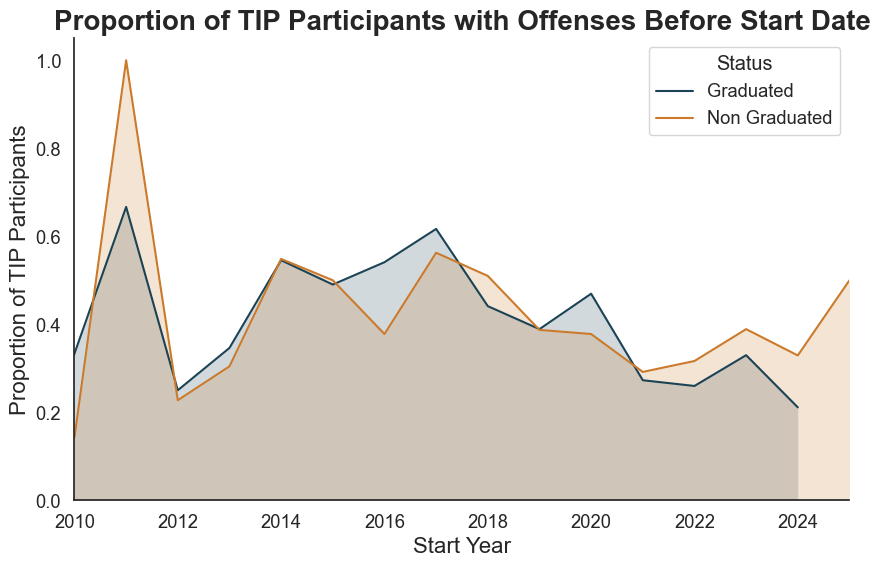

In [166]:
fig, ax = plt.subplots(figsize=(10, 6))

grouped_df = df[df['Status'] != 'Interviewed'].copy()
grouped_df['Status'] = pd.Categorical(grouped_df['Status'], categories=["Graduated", "Non Graduated"], ordered=True)

grouped_df = grouped_df.groupby(['StartYear', 'Status'])['OffenseBeforeStart'].mean().reset_index()
sns.lineplot(
    data=grouped_df,
    x='StartYear',
    y='OffenseBeforeStart',
    hue='Status',
    ax=ax
)
for status, subset in grouped_df.groupby('Status'):
    ax.fill_between(
        subset['StartYear'], subset['OffenseBeforeStart'], 0, alpha=0.2  
    )

sns.despine()

plt.title('Proportion of TIP Participants with Offenses Before Start Date', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Start Year', fontdict={'fontsize': 16})
plt.ylabel('Proportion of TIP Participants', fontdict={'fontsize': 16})
plt.ylim(0, 1.05)
plt.xlim(2010, 2025)
plt.show()

In [167]:
df_convictions = pd.merge(
    df_convictions,
    df_student[['tip_id', 'cohort_2022']],
    on='tip_id',
    how='left'
)
df_convictions['cohort_2022'] = pd.to_numeric(df_convictions['cohort_2022'], errors='coerce')
df_convictions.head

df_convictions = pd.merge(
    df_convictions,
    df[['tip_id','ValidYears','Status']],
    on='tip_id',
    how='left'
)
df_convictions.head

<bound method NDFrame.head of       tip_id         DOB GraduatedDate InterviewedDate  StartDate    EndDate  \
0          1  1992-08-26           NaT             NaT 2018-07-12 2018-08-01   
1          1  1992-08-26           NaT             NaT 2018-07-12 2018-08-01   
2          1  1992-08-26           NaT             NaT 2018-07-12 2018-08-01   
3          2  1997-01-27           NaT             NaT 2018-07-12        NaT   
4          2  1997-01-27           NaT             NaT 2018-07-12        NaT   
...      ...         ...           ...             ...        ...        ...   
5502    2307  1985-04-04           NaT      2025-01-30        NaT        NaT   
5503    2307  1985-04-04           NaT      2025-01-30        NaT        NaT   
5504    2307  1985-04-04           NaT      2025-01-30        NaT        NaT   
5505    2307  1985-04-04           NaT      2025-01-30        NaT        NaT   
5506    2309  1995-07-13           NaT      2025-01-30        NaT        NaT   

     Driv

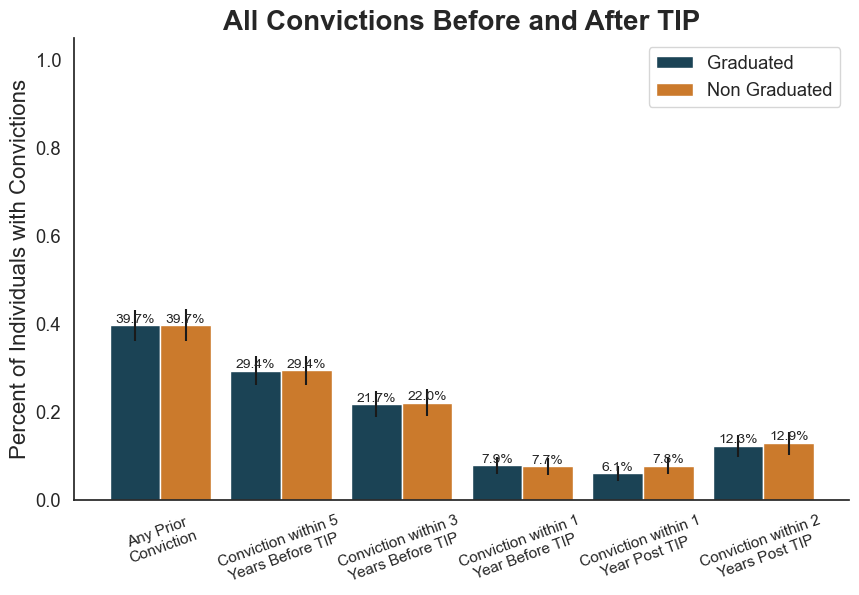

In [170]:
# ================
# CONFIG FOR FULL (COHORT 1+2)
# ================

# keep only Graduated / Non Graduated
off = df_convictions.copy()
off = off[off["Status"].isin(["Graduated", "Non Graduated"])].copy()

# -----------------------------
# 1) PRE cumulative bins
# -----------------------------

pre_bins = {
    -1: [-1],             # 1 year pre
    -3: [-3, -2, -1],     # 1-3 years pre
    -5: [-5,-4,-3,-2,-1],  #1-5 years pre
    -30: list(range(-30, 0))  # any prior usage
}

off["YearsSinceTIP_int"] = off["YearsSinceTIP"].round().astype(int)

rows = []
for bin_edge, years in pre_bins.items():
    cur = off[off["YearsSinceTIP_int"].isin(years)]
    
    row = {"YearsSinceTIP": bin_edge}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        row[status] = num
        
    rows.append(row)

pre_count = pd.DataFrame(rows)

# denominators for pre: total people per status

denom_pre = (
    df[(df["Status"].isin(["Graduated", "Non Graduated"]))]
    .groupby("Status")["tip_id"]
    .nunique()
    .to_dict()
)

z = 1.96
for status in ["Graduated", "Non Graduated"]:
    pre_count[f"{status} Percent"] = pre_count[status] / denom_pre.get(status, np.nan)
    p = pre_count[f"{status} Percent"]
    n = denom_pre.get(status, np.nan)
    se = np.sqrt(p * (1 - p) / n)
    pre_count[f"{status}_Upper_CI"] = (p + z * se).clip(0, 1)
    pre_count[f"{status}_Lower_CI"] = (p - z * se).clip(0, 1)

# -----------------------------
# 3) POST: cumulative windows [0, i) for i = 1,2 and require ValidYears > i
# -----------------------------
post_points = [1, 2]
rows = []

for i in post_points:
    cur = off[(off["YearsSinceTIP"] >= 0) & (off["YearsSinceTIP"] < i) & (off["ValidYears"] >= i)]

    row = {"YearsSinceTIP": i}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        denom = df.loc[(df["Status"] == status) & (df["ValidYears"] >= i), "tip_id"].nunique()

        p = (num / denom) if denom > 0 else 0
        se = np.sqrt(p * (1 - p) / denom) if denom > 0 else np.nan

        row[f"{status}"] = num
        row[f"{status} Percent"] = p
        row[f"{status}_Upper_CI"] = min(1, p + z * se) if denom > 0 else np.nan
        row[f"{status}_Lower_CI"] = max(0, p - z * se) if denom > 0 else np.nan

    rows.append(row)

post_df = pd.DataFrame(rows)

# -----------------------------
# 4) assemble 6 categories + plot
# -----------------------------
label_map = {
    -30: "Any Prior\nConviction",
    -5: "Conviction within 5\nYears Before TIP",
    -3:  "Conviction within 3\nYears Before TIP",
    -1:  "Conviction within 1\nYear Before TIP",
     1:  "Conviction within 1\nYear Post TIP",
     2:  "Conviction within 2\nYears Post TIP"
}
order = [-30, -5, -3, -1, 1, 2]

pre_keep = pre_count[pre_count["YearsSinceTIP"].isin([-30, -5, -3, -1])].copy()
data = pd.concat([pre_keep, post_df], ignore_index=True)

data["label"] = data["YearsSinceTIP"].astype(int).map(label_map)
data["YearsSinceTIP"] = data["YearsSinceTIP"].astype(int)
data["YearsSinceTIP"] = pd.Categorical(data["YearsSinceTIP"], categories=order, ordered=True)
data = data.sort_values("YearsSinceTIP").reset_index(drop=True)


grad_err = np.abs(
    data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values
)
non_grad_err = np.abs(
    data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values
)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(data))
width = 0.42

ax.bar(x - width/2, data["Graduated Percent"], width=width, label="Graduated", yerr=grad_err, capsize=0)
ax.bar(x + width/2, data["Non Graduated Percent"], width=width, label="Non Graduated", yerr=non_grad_err, capsize=0)

ax.set_xticks(x)
ax.set_xticklabels(data["label"], rotation=20, ha="center", fontsize=11)

for xi, yi in zip(x - width/2, data["Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)
for xi, yi in zip(x + width/2, data["Non Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)

sns.despine()
plt.title("All Convictions Before and After TIP", fontdict={"fontsize": 20, "fontweight": "semibold"})
plt.ylabel("Percent of Individuals with Convictions", fontdict={"fontsize": 16})
plt.ylim(0, 1.05)
plt.legend(loc="upper right")
plt.show()


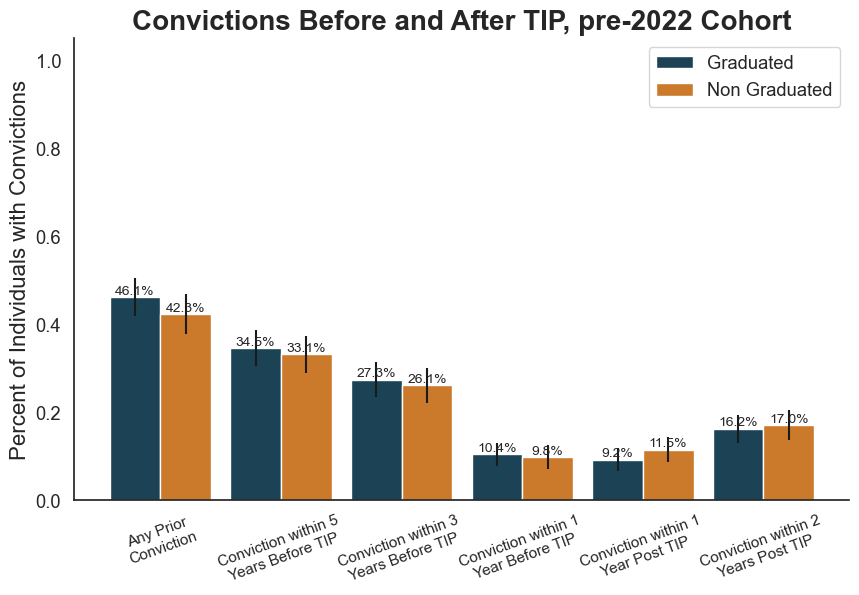

In [173]:
# ================
# CONFIG FOR COHORT 1
# ================

# keep only Graduated / Non Graduated
off = df_convictions.copy()
off = off[off["Status"].isin(["Graduated", "Non Graduated"]) & (off["cohort_2022"] == 1)].copy()

# -----------------------------
# 1) PRE cumulative bins
# -----------------------------

pre_bins = {
    -1: [-1],             # 1 year pre
    -3: [-3, -2, -1],     # 1-3 years pre
    -5: [-5,-4,-3,-2,-1],  #1-5 years pre
    -30: list(range(-30, 0))  # any prior usage
}

off["YearsSinceTIP_int"] = off["YearsSinceTIP"].round().astype(int)

rows = []
for bin_edge, years in pre_bins.items():
    cur = off[off["YearsSinceTIP_int"].isin(years)]
    
    row = {"YearsSinceTIP": bin_edge}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        row[status] = num
        
    rows.append(row)

pre_count = pd.DataFrame(rows)

# denominators for pre: total people per status

denom_pre = (
    df[(df["Status"].isin(["Graduated", "Non Graduated"]) & (df["cohort_2022"] == 1))]
    .groupby("Status")["tip_id"]
    .nunique()
    .to_dict()
)

z = 1.96
for status in ["Graduated", "Non Graduated"]:
    pre_count[f"{status} Percent"] = pre_count[status] / denom_pre.get(status, np.nan)
    p = pre_count[f"{status} Percent"]
    n = denom_pre.get(status, np.nan)
    se = np.sqrt(p * (1 - p) / n)
    pre_count[f"{status}_Upper_CI"] = (p + z * se).clip(0, 1)
    pre_count[f"{status}_Lower_CI"] = (p - z * se).clip(0, 1)

# -----------------------------
# 3) POST: cumulative windows [0, i) for i = 1,2 and require ValidYears > i
# -----------------------------
post_points = [1, 2]
rows = []

for i in post_points:
    cur = off[(off["YearsSinceTIP"] >= 0) & (off["YearsSinceTIP"] < i) & (off["ValidYears"] >= i)]

    row = {"YearsSinceTIP": i}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        denom = df.loc[(df["Status"] == status) & (df["ValidYears"] >= i) & (df["cohort_2022"] ==1), "tip_id"].nunique()

        p = (num / denom) if denom > 0 else 0
        se = np.sqrt(p * (1 - p) / denom) if denom > 0 else np.nan

        row[f"{status}"] = num
        row[f"{status} Percent"] = p
        row[f"{status}_Upper_CI"] = min(1, p + z * se) if denom > 0 else np.nan
        row[f"{status}_Lower_CI"] = max(0, p - z * se) if denom > 0 else np.nan

    rows.append(row)

post_df = pd.DataFrame(rows)

# -----------------------------
# 4) assemble 6 categories + plot
# -----------------------------
label_map = {
    -30: "Any Prior\nConviction",
    -5: "Conviction within 5\nYears Before TIP",
    -3:  "Conviction within 3\nYears Before TIP",
    -1:  "Conviction within 1\nYear Before TIP",
     1:  "Conviction within 1\nYear Post TIP",
     2:  "Conviction within 2\nYears Post TIP"
}
order = [-30, -5, -3, -1, 1, 2]

pre_keep = pre_count[pre_count["YearsSinceTIP"].isin([-30, -5, -3, -1])].copy()
data = pd.concat([pre_keep, post_df], ignore_index=True)

data["label"] = data["YearsSinceTIP"].astype(int).map(label_map)
data["YearsSinceTIP"] = data["YearsSinceTIP"].astype(int)
data["YearsSinceTIP"] = pd.Categorical(data["YearsSinceTIP"], categories=order, ordered=True)
data = data.sort_values("YearsSinceTIP").reset_index(drop=True)


grad_err = np.abs(
    data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values
)
non_grad_err = np.abs(
    data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values
)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(data))
width = 0.42

ax.bar(x - width/2, data["Graduated Percent"], width=width, label="Graduated", yerr=grad_err, capsize=0)
ax.bar(x + width/2, data["Non Graduated Percent"], width=width, label="Non Graduated", yerr=non_grad_err, capsize=0)

ax.set_xticks(x)
ax.set_xticklabels(data["label"], rotation=20, ha="center", fontsize=11)

for xi, yi in zip(x - width/2, data["Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)
for xi, yi in zip(x + width/2, data["Non Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)

sns.despine()
plt.title("Convictions Before and After TIP, pre-2022 Cohort", fontdict={"fontsize": 20, "fontweight": "semibold"})
plt.ylabel("Percent of Individuals with Convictions", fontdict={"fontsize": 16})
plt.ylim(0, 1.05)
plt.legend(loc="upper right")
plt.show()


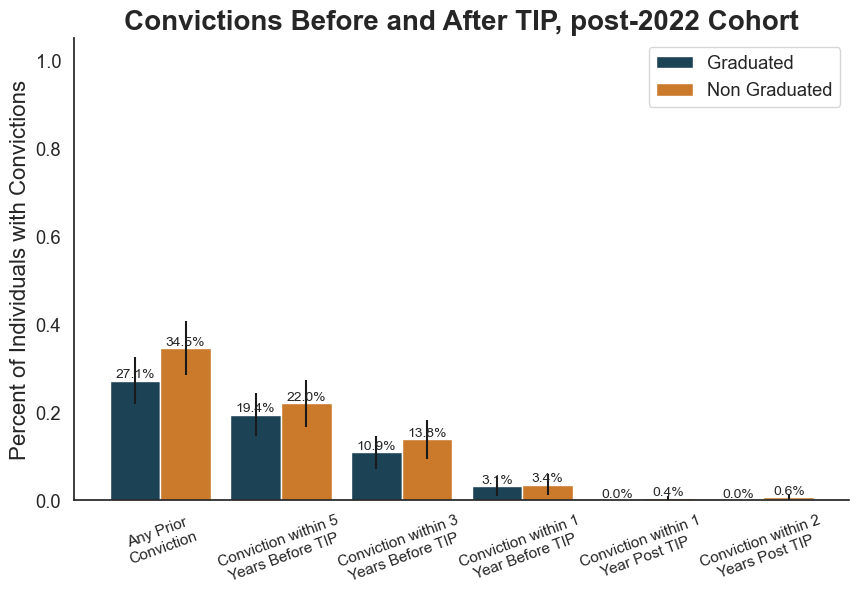

In [174]:
# ================
# CONFIG FOR COHORT 2
# ================

# keep only Graduated / Non Graduated
off = df_convictions.copy()
off = off[off["Status"].isin(["Graduated", "Non Graduated"]) & (off["cohort_2022"] == 2)].copy()

# -----------------------------
# 1) PRE cumulative bins
# -----------------------------

pre_bins = {
    -1: [-1],             # 1 year pre
    -3: [-3, -2, -1],     # 1-3 years pre
    -5: [-5,-4,-3,-2,-1],  #1-5 years pre
    -30: list(range(-30, 0))  # any prior usage
}

off["YearsSinceTIP_int"] = off["YearsSinceTIP"].round().astype(int)

rows = []
for bin_edge, years in pre_bins.items():
    cur = off[off["YearsSinceTIP_int"].isin(years)]
    
    row = {"YearsSinceTIP": bin_edge}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        row[status] = num
        
    rows.append(row)

pre_count = pd.DataFrame(rows)

# denominators for pre: total people per status

denom_pre = (
    df[(df["Status"].isin(["Graduated", "Non Graduated"]) & (df["cohort_2022"] == 2))]
    .groupby("Status")["tip_id"]
    .nunique()
    .to_dict()
)

z = 1.96
for status in ["Graduated", "Non Graduated"]:
    pre_count[f"{status} Percent"] = pre_count[status] / denom_pre.get(status, np.nan)
    p = pre_count[f"{status} Percent"]
    n = denom_pre.get(status, np.nan)
    se = np.sqrt(p * (1 - p) / n)
    pre_count[f"{status}_Upper_CI"] = (p + z * se).clip(0, 1)
    pre_count[f"{status}_Lower_CI"] = (p - z * se).clip(0, 1)

# -----------------------------
# 3) POST: cumulative windows [0, i) for i = 1,2 and require ValidYears > i
# -----------------------------
post_points = [1, 2]
rows = []

for i in post_points:
    cur = off[(off["YearsSinceTIP"] >= 0) & (off["YearsSinceTIP"] < i) & (off["ValidYears"] >= i)]

    row = {"YearsSinceTIP": i}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        denom = df.loc[(df["Status"] == status) & (df["ValidYears"] >= i) & (df["cohort_2022"] ==2), "tip_id"].nunique()

        p = (num / denom) if denom > 0 else 0
        se = np.sqrt(p * (1 - p) / denom) if denom > 0 else np.nan

        row[f"{status}"] = num
        row[f"{status} Percent"] = p
        row[f"{status}_Upper_CI"] = min(1, p + z * se) if denom > 0 else np.nan
        row[f"{status}_Lower_CI"] = max(0, p - z * se) if denom > 0 else np.nan

    rows.append(row)

post_df = pd.DataFrame(rows)

# -----------------------------
# 4) assemble 6 categories + plot
# -----------------------------
label_map = {
    -30: "Any Prior\nConviction",
    -5: "Conviction within 5\nYears Before TIP",
    -3:  "Conviction within 3\nYears Before TIP",
    -1:  "Conviction within 1\nYear Before TIP",
     1:  "Conviction within 1\nYear Post TIP",
     2:  "Conviction within 2\nYears Post TIP"
}
order = [-30, -5, -3, -1, 1, 2]

pre_keep = pre_count[pre_count["YearsSinceTIP"].isin([-30, -5, -3, -1])].copy()
data = pd.concat([pre_keep, post_df], ignore_index=True)

data["label"] = data["YearsSinceTIP"].astype(int).map(label_map)
data["YearsSinceTIP"] = data["YearsSinceTIP"].astype(int)
data["YearsSinceTIP"] = pd.Categorical(data["YearsSinceTIP"], categories=order, ordered=True)
data = data.sort_values("YearsSinceTIP").reset_index(drop=True)


grad_err = np.abs(
    data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values
)
non_grad_err = np.abs(
    data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values
)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(data))
width = 0.42

ax.bar(x - width/2, data["Graduated Percent"], width=width, label="Graduated", yerr=grad_err, capsize=0)
ax.bar(x + width/2, data["Non Graduated Percent"], width=width, label="Non Graduated", yerr=non_grad_err, capsize=0)

ax.set_xticks(x)
ax.set_xticklabels(data["label"], rotation=20, ha="center", fontsize=11)

for xi, yi in zip(x - width/2, data["Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)
for xi, yi in zip(x + width/2, data["Non Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)

sns.despine()
plt.title("Convictions Before and After TIP, post-2022 Cohort", fontdict={"fontsize": 20, "fontweight": "semibold"})
plt.ylabel("Percent of Individuals with Convictions", fontdict={"fontsize": 16})
plt.ylim(0, 1.05)
plt.legend(loc="upper right")
plt.show()


## Data Cleaning of arrest_data and Arrests Descriptive Analysis

In [867]:
df_arrests = pd.read_csv('arrest_data.csv', parse_dates=['ArrestDate', 'StartDate', 'EndDate', 'InterviewedDate', 'GraduatedDate'])
df_arrests['ArrestBeforeStart'] = df_arrests.apply(lambda x: x['ArrestDate'] < x['StartDate'] if not pd.isnull(x['StartDate']) else (x['ArrestDate'] < x['InterviewedDate'] if not pd.isnull(x['InterviewedDate']) else False), axis=1)

In [868]:
df['ArrestBeforeStart'] = df['tip_id'].apply(lambda x: x in df_arrests[df_arrests['ArrestBeforeStart'] == True]['tip_id'].unique())

C:\Users\13429\AppData\Local\Temp\ipykernel_27468\3009478391.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = grouped_df.groupby(['StartYear', 'Status'])['ArrestBeforeStart'].mean().reset_index()
C:\Users\13429\AppData\Local\Temp\ipykernel_27468\3009478391.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for status, subset in grouped_df.groupby('Status'):


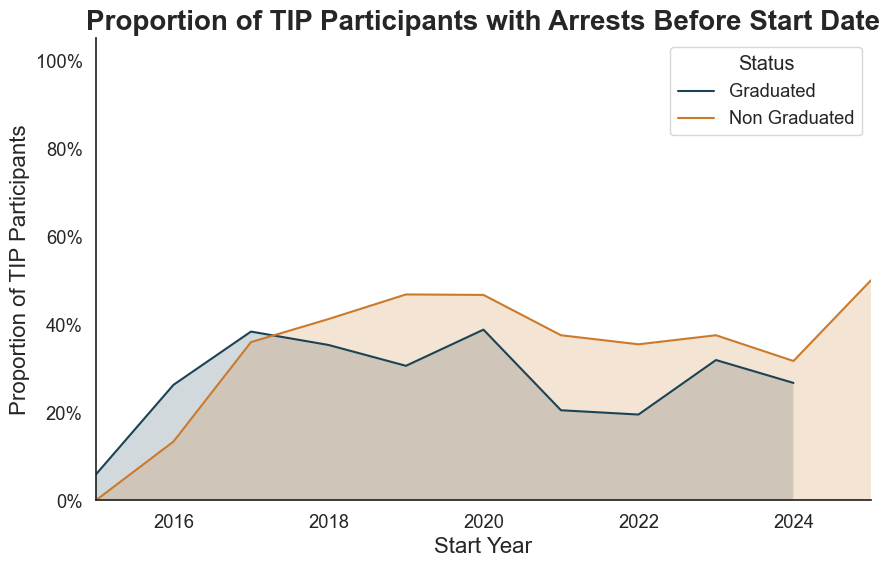

In [869]:
fig, ax = plt.subplots(figsize=(10, 6))

grouped_df = df[df['Status'] != 'Interviewed'].copy()
grouped_df['Status'] = pd.Categorical(grouped_df['Status'], categories=["Graduated", "Non Graduated"], ordered=True)

grouped_df = grouped_df.groupby(['StartYear', 'Status'])['ArrestBeforeStart'].mean().reset_index()
sns.lineplot(
    data=grouped_df,
    x='StartYear',
    y='ArrestBeforeStart',
    hue='Status',
    ax=ax
)
for status, subset in grouped_df.groupby('Status'):
    ax.fill_between(
        subset['StartYear'], subset['ArrestBeforeStart'], 0, alpha=0.2  
    )

sns.despine()

ax.yaxis.set_major_formatter('{:.0%}'.format)
plt.title('Proportion of TIP Participants with Arrests Before Start Date', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Start Year', fontdict={'fontsize': 16})
plt.ylabel('Proportion of TIP Participants', fontdict={'fontsize': 16})
plt.ylim(0, 1.05)
plt.xlim(2015, 2025)
plt.show()

## OGS

In [24]:
df_convictions = pd.merge(
    df_convictions,
    df[['tip_id', 'Status', 'ValidYears']],
    on='tip_id',
    how='left'
)

In [25]:
df_convictions_ogs = df_convictions.dropna(subset=['Status']).copy()
df_convictions_ogs = df_convictions_ogs[df_convictions_ogs['OffenseBeforeStart'] == True]
df_convictions_ogs['StartYear'] = df_convictions_ogs.apply(lambda x: x['StartDate'].year if not pd.isnull(x['StartDate']) else x['InterviewedDate'].year, axis=1)
df_convictions_ogs = df_convictions_ogs[df_convictions_ogs['Status'] != 'Interviewed']
df_convictions_ogs['Status'] = pd.Categorical(df_convictions_ogs['Status'], categories=["Graduated", "Non Graduated"], ordered=True)
df_convictions_ogs['OGS'] = df_convictions_ogs['OGS'].astype(int)

In [26]:
# The records with same tip_id, DOF, OGS, and Status are treated as duplicates
df_convictions_ogs = df_convictions_ogs.drop_duplicates(subset=["tip_id", "DOF", "OGS", "Status"])

ogs_df = pd.DataFrame(df_convictions_ogs.groupby(['OGS', 'Status']).size()).reset_index()
ogs_df.columns = ['OGS', 'Status', 'Count']
ogs_df['Percentage'] = ogs_df['Count'] / ogs_df['Count'].sum()
ogs_df = ogs_df.pivot(index='OGS', columns='Status', values=['Percentage', 'Count'])
ogs_df.columns = ['Graduated_Percentage', 'Non Graduated_Percentage', 'Graduated_Count', 'Non Graduated_Count']
ogs_df = ogs_df.reset_index()

C:\Users\sarah\AppData\Local\Temp\ipykernel_31296\1743254842.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ogs_df = pd.DataFrame(df_convictions_ogs.groupby(['OGS', 'Status']).size()).reset_index()


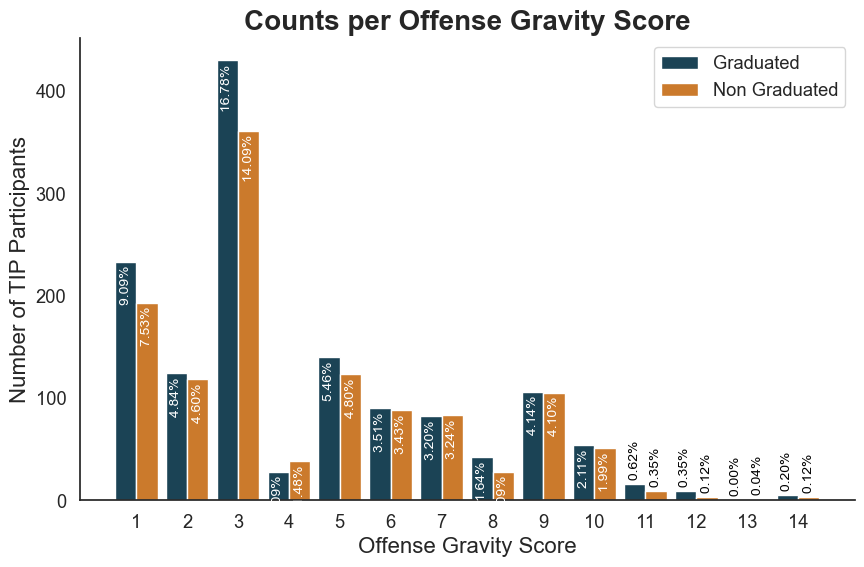

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

x_indexes = np.arange(len(ogs_df))

bar_width = 0.42

plt.bar(
    x_indexes - bar_width / 2,
    ogs_df['Graduated_Count'],
    width=bar_width,
    label='Graduated',
    color=TIP_colors[0]
)

plt.bar(
    x_indexes + bar_width / 2,
    ogs_df['Non Graduated_Count'],
    width=bar_width,
    label='Non Graduated',
    color=TIP_colors[1]
)

for i, (x, y, upper, y2, upper2) in enumerate(zip(x_indexes, ogs_df['Graduated_Percentage'], ogs_df['Graduated_Count'], ogs_df['Non Graduated_Percentage'], ogs_df['Non Graduated_Count'])):
    if i >= 10:
        continue
    plt.text(x - bar_width / 2, upper + 0.01, f'{y:.2%} ', ha='center', va='top', fontsize=10, rotation=90, color='white')
    plt.text(x + bar_width / 2, upper2 + 0.01, f'{y2:.2%} ', ha='center', va='top', fontsize=10, rotation=90, color='white')

for i, (x, y, upper, y2, upper2) in enumerate(zip(x_indexes, ogs_df['Graduated_Percentage'], ogs_df['Graduated_Count'], ogs_df['Non Graduated_Percentage'], ogs_df['Non Graduated_Count'])):
    if i < 10:
        continue
    plt.text(x - bar_width / 2, upper + 0.01, f' {y:.2%}', ha='center', va='bottom', fontsize=10, rotation=90, color='black')
    plt.text(x + bar_width / 2, upper2 + 0.01, f' {y2:.2%}', ha='center', va='bottom', fontsize=10, rotation=90, color='black')

sns.despine()

plt.xticks(ticks=x_indexes, labels=ogs_df['OGS'], rotation=0)
plt.legend()
plt.title('Counts per Offense Gravity Score', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('Offense Gravity Score', fontdict={'fontsize': 16})
plt.ylabel('Number of TIP Participants', fontdict={'fontsize': 16})
plt.show()

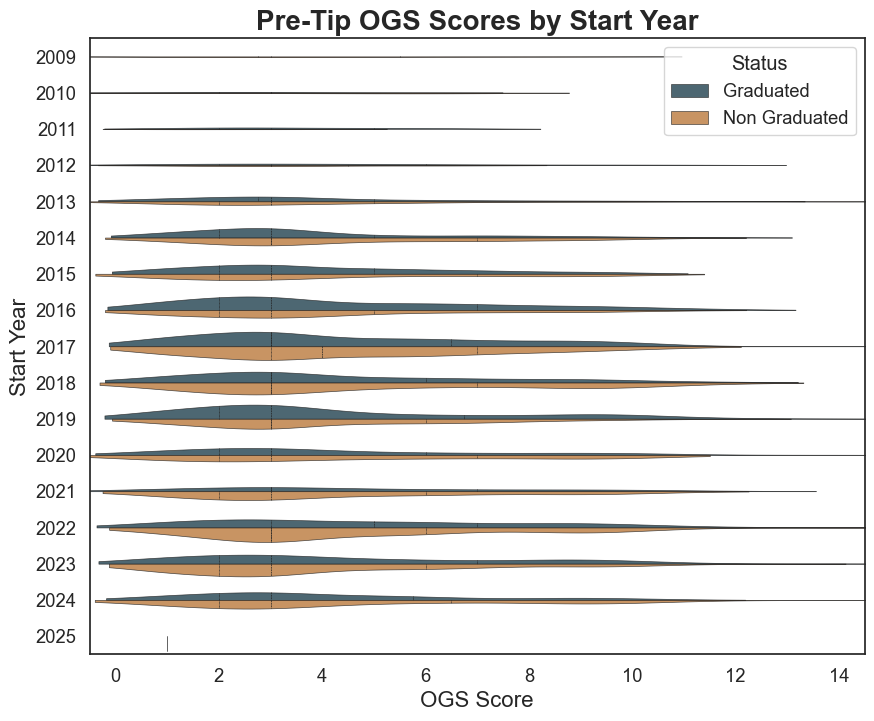

In [28]:
plt.figure(figsize=(10, 8))

sns.violinplot(
    data = df_convictions_ogs,
    y='StartYear',
    x='OGS',
    hue='Status',
    split=True,
    inner='quart',
    orient='h',
    saturation=0.8,
    dodge=True,
    cut=1.1,
    density_norm='count',
    linewidth=0.5,
    alpha=0.8
)

plt.title('Pre-Tip OGS Scores by Start Year', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.ylabel('Start Year', fontdict={'fontsize': 16})
plt.xlabel('OGS Score', fontdict={'fontsize': 16})
plt.xlim(-0.5, 14.5)
plt.show()

## Criminal Justice Interactions

In [29]:
def years_since_TIP(row):
    val = 0
    dof = row['DOF']
    if not pd.isnull(row['StartDate']):
        start = row['StartDate']
    else:
        start = row['InterviewedDate']
    if not pd.isnull(row['GraduatedDate']):
        end = row['GraduatedDate']
    else:
        end = row['EndDate']

    if pd.isnull(start) and pd.isnull(end):
        return None

    if dof > start:
        val = (dof - end).days/365.2425
    elif dof < start:
        val = -(start - dof).days/365.2425
    return val

df_convictions['YearsSinceTIP'] = df_convictions.apply(years_since_TIP, axis=1)

In [30]:
df_arrests = pd.merge(
    df_arrests,
    df[['tip_id', 'Status', 'ValidYears']],
    on='tip_id',
    how='left'
)

NameError: name 'df_arrests' is not defined

In [877]:
df_arrests['DOF'] = df_arrests['ArrestDate']
df_arrests['YearsSinceTIP'] = df_arrests.apply(years_since_TIP, axis=1)

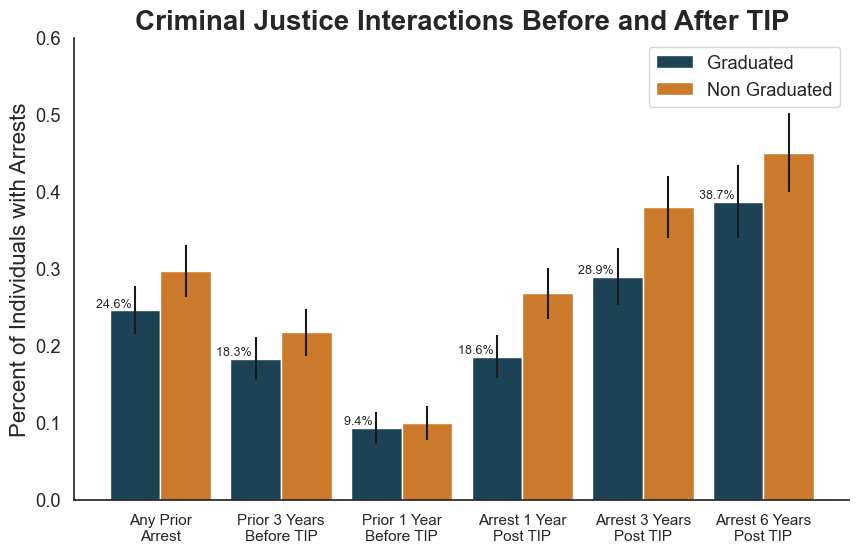

In [878]:
data_before = []
for i in np.arange(-30, 0.5, 0.2):
    i = round(i, 1)
    curr_grads = df_arrests[(df_arrests['YearsSinceTIP'] >= i) & (df_arrests['YearsSinceTIP'] < 0) & (df_arrests['Status'] == 'Graduated')].copy()
    curr_non_grads = df_arrests[(df_arrests['YearsSinceTIP'] >= i) & (df_arrests['YearsSinceTIP'] < 0) & (df_arrests['Status'] == 'Non Graduated')].copy()
    curr_interviewed = df_arrests[(df_arrests['YearsSinceTIP'] >= i) & (df_arrests['YearsSinceTIP'] < 0) & (df_arrests['Status'] == 'Interviewed')].copy()
    data_before.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : curr_grads['tip_id'].nunique() / df[df['Status'] == 'Graduated'].tip_id.nunique(),
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : curr_non_grads['tip_id'].nunique() / df[df['Status'] == 'Non Graduated'].tip_id.nunique(),
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : curr_interviewed['tip_id'].nunique() / df[df['Status'] == 'Interviewed'].tip_id.nunique()
    })

data_before = pd.DataFrame(data_before)

data_after = []
for i in np.arange(0, 30.2, 0.2):
    curr_grads = df_arrests[(df_arrests['YearsSinceTIP'] >= 0) & (df_arrests['YearsSinceTIP'] < i) & (df_arrests['Status'] == 'Graduated') & (df_arrests['ValidYears'] > i)].copy()
    curr_non_grads = df_arrests[(df_arrests['YearsSinceTIP'] >= 0) & (df_arrests['YearsSinceTIP'] < i) & (df_arrests['Status'] == 'Non Graduated') & (df_arrests['ValidYears'] > i)].copy()
    curr_interviewed = df_arrests[(df_arrests['YearsSinceTIP'] >= 0) & (df_arrests['YearsSinceTIP'] < i) & (df_arrests['Status'] == 'Interviewed') & (df_arrests['ValidYears'] > i)].copy()

    graduate_pop_size = df[(df['Status'] == 'Graduated') & (df['ValidYears'] > i)].tip_id.nunique()
    non_graduate_pop_size = df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > i)].tip_id.nunique()
    interviewed_pop_size = df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > i)].tip_id.nunique()

    data_after.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : (curr_grads['tip_id'].nunique() / graduate_pop_size) if graduate_pop_size > 0 else 0,
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : (curr_non_grads['tip_id'].nunique() / non_graduate_pop_size) if non_graduate_pop_size > 0 else 0,
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : (curr_interviewed['tip_id'].nunique() / interviewed_pop_size) if interviewed_pop_size > 0 else 0
    })

data_after = pd.DataFrame(data_after)

data_before['Graduated_Upper_CI'] = data_before['Graduated Percent'] + 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df[df['Status'] == 'Graduated'].tip_id.nunique())
data_before['Graduated_Lower_CI'] = data_before['Graduated Percent'] - 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df[df['Status'] == 'Graduated'].tip_id.nunique())
data_before['Non Graduated_Upper_CI'] = data_before['Non Graduated Percent'] + 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df[df['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Non Graduated_Lower_CI'] = data_before['Non Graduated Percent'] - 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df[df['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Interviewed_Upper_CI'] = data_before['Interviewed Percent'] + 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df[df['Status'] == 'Interviewed'].tip_id.nunique())
data_before['Interviewed_Lower_CI'] = data_before['Interviewed Percent'] - 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df[df['Status'] == 'Interviewed'].tip_id.nunique())

data_after['Graduated_Upper_CI'] = data_after['Graduated Percent'] + 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Graduated')].tip_id.nunique()))
data_after['Graduated_Lower_CI'] = data_after['Graduated Percent'] - 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Graduated')].tip_id.nunique()))
data_after['Non Graduated_Upper_CI'] = data_after['Non Graduated Percent'] + 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Non Graduated')].tip_id.nunique()))
data_after['Non Graduated_Lower_CI'] = data_after['Non Graduated Percent'] - 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Non Graduated') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Non Graduated')].tip_id.nunique()))
data_after['Interviewed_Upper_CI'] = data_after['Interviewed Percent'] + 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Interviewed')].tip_id.nunique()))
data_after['Interviewed_Lower_CI'] = data_after['Interviewed Percent'] - 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df[(df['Status'] == 'Interviewed') & (df['ValidYears'] > x)].tip_id.nunique() if x > 0 else df[(df['Status'] == 'Interviewed')].tip_id.nunique()))

data = pd.concat([
    data_before[(data_before['YearsSinceTIP'] == -1) | (data_before['YearsSinceTIP'] == -3) | (data_before['YearsSinceTIP'] == -30)],
    data_after[(data_after['YearsSinceTIP'] == 1) | (data_after['YearsSinceTIP'] == 3) | (data_after['YearsSinceTIP'] == 6)]
])

data = data.drop(columns=['Interviewed', 'Interviewed Percent', 'Interviewed_Lower_CI', 'Interviewed_Upper_CI'])
data['YearsSinceTIP'] = data['YearsSinceTIP'].astype(str)
data['YearsSinceTIP'] = [
    "Any Prior Arrest", 
    "Prior 3 Years Before TIP", 
    "Prior 1 Year Before TIP", 
    "Arrest 1 Year Post TIP", 
    "Arrest 3 Years Post TIP", 
    "Arrest 6 Years Post TIP"
]

grad_err = np.abs(data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values)
non_grad_err = np.abs(data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values)

fig, ax = plt.subplots(figsize=(10, 6))

x_indexes = np.arange(len(data))
width = 0.42

ax.bar(
    x_indexes - width/2,
    data['Graduated Percent'],
    width=width,
    label='Graduated',
    yerr=grad_err,
    capsize=0
)

ax.bar(
    x_indexes + width/2,
    data['Non Graduated Percent'],
    width=width,
    label='Non Graduated',
    yerr=non_grad_err,
    capsize=0,
)


ax.set_xticks(x_indexes)
ax.set_xticklabels([
    "Any Prior\nArrest", 
    "Prior 3 Years\nBefore TIP", 
    "Prior 1 Year\nBefore TIP", 
    "Arrest 1 Year\nPost TIP", 
    "Arrest 3 Years\nPost TIP", 
    "Arrest 6 Years\nPost TIP"
], rotation=0, ha='center', fontsize=11)

for i, (x, y, upper, lower) in enumerate(zip(x_indexes - width/2, data['Graduated Percent'], data['Graduated_Upper_CI'], data['Graduated_Lower_CI'])):
    ax.text(x, y, f"{y:.1%} ", ha='right', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

# for i, (x, y, upper, lower) in enumerate(zip(x_indexes + width/2, data['Non Graduated Percent'], data['Non Graduated_Upper_CI'], data['Non Graduated_Lower_CI'])):
#     ax.text(x, y, f" {y:.1%}", ha='left', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

sns.despine()

plt.title('Criminal Justice Interactions Before and After TIP', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('', fontdict={'fontsize': 0})
plt.ylabel('Percent of Individuals with Arrests', fontdict={'fontsize': 16})
plt.ylim(0, 0.6)
plt.legend()
plt.show()


In [879]:
df_2022 = df[df['StartYear'] >= 2022].copy()

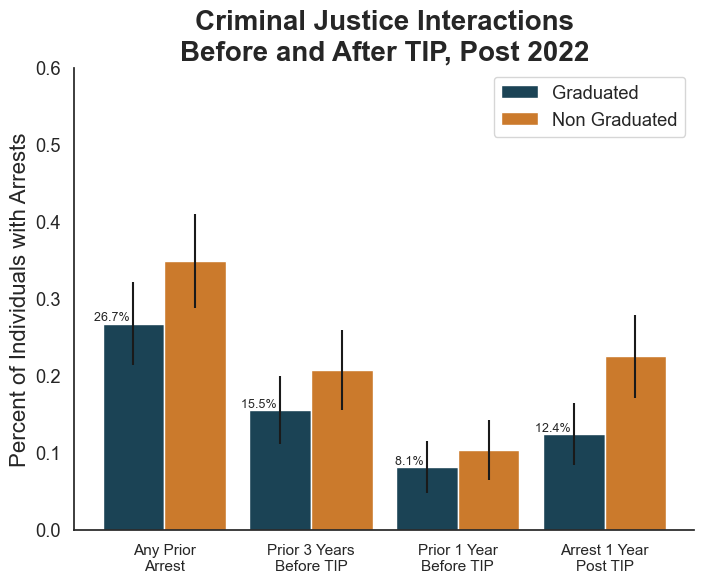

In [880]:
df_arrests_2022 = df_arrests[df_arrests['tip_id'].isin(df_2022['tip_id'])]
data_before = []
for i in np.arange(-30, 0.5, 0.2):
    i = round(i, 1)
    curr_grads = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= i) & (df_arrests_2022['YearsSinceTIP'] < 0) & (df_arrests_2022['Status'] == 'Graduated')].copy()
    curr_non_grads = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= i) & (df_arrests_2022['YearsSinceTIP'] < 0) & (df_arrests_2022['Status'] == 'Non Graduated')].copy()
    curr_interviewed = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= i) & (df_arrests_2022['YearsSinceTIP'] < 0) & (df_arrests_2022['Status'] == 'Interviewed')].copy()
    data_before.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : curr_grads['tip_id'].nunique() / df_2022[df_2022['Status'] == 'Graduated'].tip_id.nunique(),
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : curr_non_grads['tip_id'].nunique() / df_2022[df_2022['Status'] == 'Non Graduated'].tip_id.nunique(),
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : curr_interviewed['tip_id'].nunique() / df_2022[df_2022['Status'] == 'Interviewed'].tip_id.nunique()
    })

data_before = pd.DataFrame(data_before)

data_after = []
for i in np.arange(0, 30.2, 0.2):
    curr_grads = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= 0) & (df_arrests_2022['YearsSinceTIP'] < i) & (df_arrests_2022['Status'] == 'Graduated') & (df_arrests_2022['ValidYears'] > i)].copy()
    curr_non_grads = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= 0) & (df_arrests_2022['YearsSinceTIP'] < i) & (df_arrests_2022['Status'] == 'Non Graduated') & (df_arrests_2022['ValidYears'] > i)].copy()
    curr_interviewed = df_arrests_2022[(df_arrests_2022['YearsSinceTIP'] >= 0) & (df_arrests_2022['YearsSinceTIP'] < i) & (df_arrests_2022['Status'] == 'Interviewed') & (df_arrests_2022['ValidYears'] > i)].copy()

    graduate_pop_size = df_2022[(df_2022['Status'] == 'Graduated') & (df_2022['ValidYears'] > i)].tip_id.nunique()
    non_graduate_pop_size = df_2022[(df_2022['Status'] == 'Non Graduated') & (df_2022['ValidYears'] > i)].tip_id.nunique()
    interviewed_pop_size = df_2022[(df_2022['Status'] == 'Interviewed') & (df_2022['ValidYears'] > i)].tip_id.nunique()

    data_after.append({
        'YearsSinceTIP': i,
        'Graduated': curr_grads['tip_id'].nunique(),
        'Graduated Percent' : (curr_grads['tip_id'].nunique() / graduate_pop_size) if graduate_pop_size > 0 else 0,
        'Non Graduated': curr_non_grads['tip_id'].nunique(),
        'Non Graduated Percent' : (curr_non_grads['tip_id'].nunique() / non_graduate_pop_size) if non_graduate_pop_size > 0 else 0,
        'Interviewed': curr_interviewed['tip_id'].nunique(),
        'Interviewed Percent' : (curr_interviewed['tip_id'].nunique() / interviewed_pop_size) if interviewed_pop_size > 0 else 0
    })

data_after = pd.DataFrame(data_after)

data_before['Graduated_Upper_CI'] = data_before['Graduated Percent'] + 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df_2022[df_2022['Status'] == 'Graduated'].tip_id.nunique())
data_before['Graduated_Lower_CI'] = data_before['Graduated Percent'] - 1.96 * np.sqrt(data_before['Graduated Percent'] * (1 - data_before['Graduated Percent']) / df_2022[df_2022['Status'] == 'Graduated'].tip_id.nunique())
data_before['Non Graduated_Upper_CI'] = data_before['Non Graduated Percent'] + 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df_2022[df_2022['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Non Graduated_Lower_CI'] = data_before['Non Graduated Percent'] - 1.96 * np.sqrt(data_before['Non Graduated Percent'] * (1 - data_before['Non Graduated Percent']) / df_2022[df_2022['Status'] == 'Non Graduated'].tip_id.nunique())
data_before['Interviewed_Upper_CI'] = data_before['Interviewed Percent'] + 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df_2022[df_2022['Status'] == 'Interviewed'].tip_id.nunique())
data_before['Interviewed_Lower_CI'] = data_before['Interviewed Percent'] - 1.96 * np.sqrt(data_before['Interviewed Percent'] * (1 - data_before['Interviewed Percent']) / df_2022[df_2022['Status'] == 'Interviewed'].tip_id.nunique())

data_after['Graduated_Upper_CI'] = data_after['Graduated Percent'] + 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Graduated') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Graduated')].tip_id.nunique()))
data_after['Graduated_Lower_CI'] = data_after['Graduated Percent'] - 1.96 * np.sqrt(data_after['Graduated Percent'] * (1 - data_after['Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Graduated') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Graduated')].tip_id.nunique()))
data_after['Non Graduated_Upper_CI'] = data_after['Non Graduated Percent'] + 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Non Graduated') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Non Graduated')].tip_id.nunique()))
data_after['Non Graduated_Lower_CI'] = data_after['Non Graduated Percent'] - 1.96 * np.sqrt(data_after['Non Graduated Percent'] * (1 - data_after['Non Graduated Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Non Graduated') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Non Graduated')].tip_id.nunique()))
data_after['Interviewed_Upper_CI'] = data_after['Interviewed Percent'] + 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Interviewed') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Interviewed')].tip_id.nunique()))
data_after['Interviewed_Lower_CI'] = data_after['Interviewed Percent'] - 1.96 * np.sqrt(data_after['Interviewed Percent'] * (1 - data_after['Interviewed Percent']) / data_after['YearsSinceTIP'].apply(lambda x: df_2022[(df_2022['Status'] == 'Interviewed') & (df_2022['ValidYears'] > x)].tip_id.nunique() if x > 0 else df_2022[(df_2022['Status'] == 'Interviewed')].tip_id.nunique()))

data = pd.concat([
    data_before[(data_before['YearsSinceTIP'] == -1) | (data_before['YearsSinceTIP'] == -3) | (data_before['YearsSinceTIP'] == -30)],
    data_after[(data_after['YearsSinceTIP'] == 1)]
])

data = data.drop(columns=['Interviewed', 'Interviewed Percent', 'Interviewed_Lower_CI', 'Interviewed_Upper_CI'])
data['YearsSinceTIP'] = data['YearsSinceTIP'].astype(str)
data['YearsSinceTIP'] = [
    "Any Prior Arrest", 
    "Prior 3 Years Before TIP", 
    "Prior 1 Year Before TIP", 
    "Arrest 1 Year Post TIP", 
]

grad_err = np.abs(data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values)
non_grad_err = np.abs(data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values)

fig, ax = plt.subplots(figsize=(8, 6))

x_indexes = np.arange(len(data))
width = 0.42

ax.bar(
    x_indexes - width/2,
    data['Graduated Percent'],
    width=width,
    label='Graduated',
    yerr=grad_err,
    capsize=0
)

ax.bar(
    x_indexes + width/2,
    data['Non Graduated Percent'],
    width=width,
    label='Non Graduated',
    yerr=non_grad_err,
    capsize=0,
)


ax.set_xticks(x_indexes)
ax.set_xticklabels([
    "Any Prior\nArrest", 
    "Prior 3 Years\nBefore TIP", 
    "Prior 1 Year\nBefore TIP", 
    "Arrest 1 Year\nPost TIP", 
], rotation=0, ha='center', fontsize=11)

for i, (x, y, upper, lower) in enumerate(zip(x_indexes - width/2, data['Graduated Percent'], data['Graduated_Upper_CI'], data['Graduated_Lower_CI'])):
    ax.text(x, y, f"{y:.1%} ", ha='right', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

# for i, (x, y, upper, lower) in enumerate(zip(x_indexes + width/2, data['Non Graduated Percent'], data['Non Graduated_Upper_CI'], data['Non Graduated_Lower_CI'])):
#     ax.text(x, y, f" {y:.1%}", ha='left', va='bottom', fontsize=9, fontdict={'fontweight': 'medium'})

sns.despine()

plt.title('Criminal Justice Interactions\nBefore and After TIP, Post 2022', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlabel('', fontdict={'fontsize': 0})
plt.ylabel('Percent of Individuals with Arrests', fontdict={'fontsize': 16})
plt.ylim(0, 0.6)
plt.legend()
plt.show()


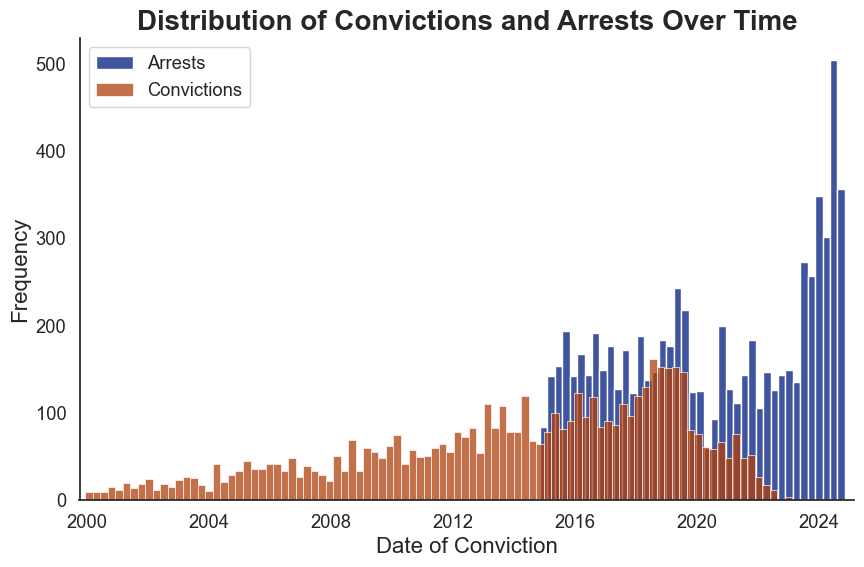

In [881]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    df_arrests['DOF'],
    binwidth=90,
    color=sns.color_palette('dark')[0]
)

sns.histplot(
    df_convictions['DOF'],
    binwidth=90,
    color=sns.color_palette('dark')[1]
)

sns.despine()

plt.title('Distribution of Convictions and Arrests Over Time', fontdict={'fontsize': 20, 'fontweight': 'semibold'})
plt.xlim(pd.Timestamp('1999-10-01'), pd.Timestamp('2025-02-28'))
plt.xlabel('Date of Conviction', fontdict={'fontsize': 16})
plt.ylabel('Frequency', fontdict={'fontsize': 16})
plt.legend(['Arrests', 'Convictions'])
plt.show()


## Data Cleaning of tip_cohort_uiearnings and Employment Descriptive Analysis

In [175]:
df_earnings = pd.read_csv(r'C:\Users\sarah\Documents\CMU\Spring 2026\Systems Synthesis\Data\Post-Cleaning\tip_earn.csv')
df_inflation = pd.read_csv(r'C:\Users\sarah\Downloads\inflation_data.csv')

C:\Users\sarah\AppData\Local\Temp\ipykernel_31296\4200840025.py:1: DtypeWarning: Columns (3,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_earnings = pd.read_csv(r'C:\Users\sarah\Documents\CMU\Spring 2026\Systems Synthesis\Data\Post-Cleaning\tip_earn.csv')


In [176]:
# process quarter to datetime
q_str = df_earnings["quarter"].astype(str).str.strip()

df_earnings["year"] = q_str.str[:4].astype(int)
df_earnings["qnum"] = q_str.str[-1].astype(int)  # 1-4

# map to calendar quarter end month/day
# Q1 -> 03/31
# Q2 -> 06/30
# Q3 -> 09/30
# Q4 -> 12/31 
month_map = {1: 3, 2: 6, 3: 9, 4: 12}
day_map   = {1: 31, 2: 30, 3: 30, 4: 31}

df_earnings["cal_end_year"] = df_earnings["year"]
df_earnings["cal_end_month"] = df_earnings["qnum"].map(month_map)
df_earnings["cal_end_day"] = df_earnings["qnum"].map(day_map)

df_earnings["year_quarter_dt"] = pd.to_datetime(
    dict(
        year=df_earnings["cal_end_year"],
        month=df_earnings["cal_end_month"],
        day=df_earnings["cal_end_day"],
    ),
    errors="coerce",
)

df_earnings["year_month"] = df_earnings["year_quarter_dt"].dt.to_period("M")
df_earnings.drop(columns=["Unnamed: 0", "qnum", "cal_end_year", "cal_end_month", "cal_end_day"], errors="ignore", inplace=True)

In [177]:
df_earnings.head()

,tip_id,quarter,employer_legal_name,earnings,naics_code,naics_sector_2017,naics_subsector_2017,naics_industry_2017,naics_sector_2022,naics_subsector_2022,naics_industry_2022,year,year_quarter_dt,year_month
0,655,20182,LEHIGH VALLEY RESTAURANT GROUP INC,1434,722511.0,Accommodation and food services,Food services and drinking places,Full-Service Restaurants,Accommodation and Food Services,Food Services and Drinking Places,Full-Service Restaurants,2018,2018-06-30,2018-06
1,556,20174,COST COMPANY,3147,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2017,2017-12-31,2017-12
2,556,20174,FRANCO,4654,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2017,2017-12-31,2017-12
3,556,20181,COST COMPANY,1908,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2018,2018-03-31,2018-03
4,556,20181,FRANCO,7165,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2018,2018-03-31,2018-03


In [178]:
# adjust income data for inflation
df_inflation.drop(columns=['HALF1', 'HALF2'], inplace=True)
df_inflation = df_inflation.melt(id_vars='Year', var_name='Month', value_name='CPI')

month_map = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
             'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
df_inflation["year_month"] = (
    df_inflation["Year"].astype(str) + "-" + df_inflation["Month"].map(month_map)
)
# sort by date to ensure that the latest CPI value is at the end of the DataFrame
df_inflation = df_inflation.sort_values("year_month").reset_index(drop=True)
latest_cpi = df_inflation.loc[df_inflation["year_month"] == "2025-12", "CPI"].iloc[0]

df_earnings["year_month"] = df_earnings["year_month"].astype(str)

cpi_map = df_inflation.drop_duplicates("year_month").set_index("year_month")["CPI"]
df_earnings["CPI"] = df_earnings["year_month"].map(cpi_map)

df_earnings["adjusted_earnings"] = df_earnings["earnings"] * (latest_cpi / df_earnings["CPI"])

In [179]:
df_earnings.head()

,tip_id,quarter,employer_legal_name,earnings,naics_code,naics_sector_2017,naics_subsector_2017,naics_industry_2017,naics_sector_2022,naics_subsector_2022,naics_industry_2022,year,year_quarter_dt,year_month,CPI,adjusted_earnings
0,655,20182,LEHIGH VALLEY RESTAURANT GROUP INC,1434,722511.0,Accommodation and food services,Food services and drinking places,Full-Service Restaurants,Accommodation and Food Services,Food Services and Drinking Places,Full-Service Restaurants,2018,2018-06-30,2018-06,251.989,1844.102068
1,556,20174,COST COMPANY,3147,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2017,2017-12-31,2017-12,246.524,4136.708548
2,556,20174,FRANCO,4654,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2017,2017-12-31,2017-12,246.524,6117.649056
3,556,20181,COST COMPANY,1908,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2018,2018-03-31,2018-03,249.554,2477.600167
4,556,20181,FRANCO,7165,238142.0,Construction,Specialty trade contractors,Masonry Contractors - Nonresidential,Construction,Specialty Trade Contractors,Masonry Contractors (non-residential),2018,2018-03-31,2018-03,249.554,9303.985951


In [180]:
df_e = df_earnings.merge(
    df[["tip_id", "StartDate", "StartYear", "Status"]],
    on="tip_id",
    how="left"
)

df_e["distance_from_TIP"] = df_e["year"] - df_e["StartYear"]

# pre/post per quarter
# StartDate <= year_quarter_dt -> post
# StartDate > year_quarter_dt -> pre
df_e["pre_post_q"] = np.where(
    df_e["StartDate"].isna() | df_e["year_quarter_dt"].isna(),
    "N/A",
    np.where(df_e["StartDate"] < df_e["year_quarter_dt"], "post", "pre")
)

# mean annual earnings
tmp = (
    df_e[df_e["pre_post_q"].isin(["pre", "post"])]
    .groupby(["tip_id", "pre_post_q"])["adjusted_earnings"]
    .mean()
    .unstack("pre_post_q")
)
tmp["earnings_pre"] = tmp["pre"] * 4
tmp["earnings_post"] = tmp["post"] * 4

# change metrics
tmp["abs_change"] = tmp["earnings_post"] - tmp["earnings_pre"]
tmp["per_change"] = (tmp["earnings_post"] - tmp["earnings_pre"]) / tmp["earnings_pre"]

tmp.loc[(tmp["earnings_pre"].isna()) | (tmp["earnings_pre"] == 0), "per_change"] = np.nan

# student-level results
earn_change = tmp[["earnings_pre", "earnings_post", "abs_change", "per_change"]].reset_index()

# merge back to df (one row per tip_id)
df = df.merge(earn_change, on="tip_id", how="left")

In [181]:
earn_change.head()

pre_post_q,tip_id,earnings_pre,earnings_post,abs_change,per_change
0,1,273.40189,35199.695031,34926.29314,127.74708
1,4,NaN,11268.428573,NaN,NaN
2,6,NaN,167.649838,NaN,NaN
3,7,NaN,2323.775815,NaN,NaN
4,8,NaN,7114.669401,NaN,NaN


In [182]:
df.columns

Index(['tip_id', 'GraduatedDate', 'InterviewedDate', 'StartDate', 'EndDate',
       'DriversLicense', 'Course', 'CreatedDate', 'Status', 'age',
       'cohort_2022', 'StartYear', 'census_tract', 'gender', 'race',
       'ValidYears', 'OffenseBeforeStart', 'earnings_pre', 'earnings_post',
       'abs_change', 'per_change'],
      dtype='object')

In [183]:
# define employment status based on whether tip_id exists in df_earnings
def has_employment(tip_id):
    return tip_id in df_earnings['tip_id'].unique()

df['has_employment'] = df['tip_id'].apply(has_employment)

In [184]:
df_grad = df[df["Status"] == "Graduated"].copy()
df_non_grad = df[df["Status"] == "Non Graduated"].copy()
df_grad.head()

,tip_id,GraduatedDate,InterviewedDate,StartDate,EndDate,DriversLicense,Course,CreatedDate,Status,age,...,census_tract,gender,race,ValidYears,OffenseBeforeStart,earnings_pre,earnings_post,abs_change,per_change,has_employment
1,4,2013-10-16,NaT,2013-08-12,2013-10-16,NaN,Introduction to Masonry,2018-07-12,Graduated,30.0,...,4.200313e+10,Male,Black,12.331280,False,NaN,11268.428573,NaN,NaN,True
2,5,2011-02-04,NaT,2010-11-29,2011-02-04,NaN,Introduction to Masonry,2018-07-12,Graduated,22.0,...,NaN,NaN,NaN,15.028063,False,NaN,NaN,NaN,NaN,False
5,8,2012-04-12,NaT,2012-02-13,2012-04-12,NaN,Introduction to Masonry,2018-07-12,Graduated,22.0,...,4.200313e+10,Male,Black,13.842574,False,NaN,7114.669401,NaN,NaN,True
7,10,2018-01-02,NaT,2018-01-01,2018-01-02,NaN,Introduction to Masonry,2018-07-12,Graduated,28.0,...,4.200301e+10,Male,Black,8.117728,True,186.657964,854.385211,667.727247,3.577277,True
8,11,2013-05-10,NaT,2013-02-27,2013-05-10,NaN,Introduction to Masonry,2018-07-12,Graduated,41.0,...,NaN,NaN,NaN,12.766598,False,NaN,NaN,NaN,NaN,False


In [185]:
for name, target_df in [("Graduated", df_grad), ("Non Graduated", df_non_grad)]:
    print("\n" + "=" * 30)
    print(f"{name}: pre-TIP annual earnings (earnings_pre)")
    print("=" * 30)

    s = pd.to_numeric(target_df["earnings_pre"], errors="coerce").dropna()

    stats = pd.Series(
        {
            "N (non-missing)": int(s.shape[0]),
            "Mean": round(s.mean(), 2) if s.shape[0] else np.nan,
            "Median": round(s.median(), 2) if s.shape[0] else np.nan,
        }
    )
    print(stats)


Graduated: pre-TIP annual earnings (earnings_pre)
N (non-missing)     492.00
Mean               6736.61
Median             4123.93
dtype: float64

Non Graduated: pre-TIP annual earnings (earnings_pre)
N (non-missing)     475.00
Mean               4757.54
Median             2303.86
dtype: float64


In [188]:
df_grad_c1 = df_grad[df_grad["cohort_2022"] == 1].copy()
df_nongrad_c1 = df_non_grad[df_non_grad["cohort_2022"] == 1].copy()

print("\n" + "#" * 40)
print("PRE-2022 COHORT")
print("#" * 40)

for name, target_df in [("Graduated", df_grad_c1), ("Non Graduated", df_nongrad_c1)]:
    print("\n" + "=" * 30)
    print(f"{name}: pre-TIP annual earnings (earnings_pre)")
    print("=" * 30)

    s = pd.to_numeric(target_df["earnings_pre"], errors="coerce").dropna()

    stats = pd.Series(
        {
            "N (non-missing)": int(s.shape[0]),
            "Mean": round(s.mean(), 2) if s.shape[0] else np.nan,
            "Median": round(s.median(), 2) if s.shape[0] else np.nan,
        }
    )
    print(stats)


########################################
PRE-2022 COHORT
########################################

Graduated: pre-TIP annual earnings (earnings_pre)
N (non-missing)     258.00
Mean               6009.56
Median             3227.79
dtype: float64

Non Graduated: pre-TIP annual earnings (earnings_pre)
N (non-missing)     260.00
Mean               4901.49
Median             1841.02
dtype: float64


In [189]:
df_grad_c2 = df_grad[df_grad["cohort_2022"] == 2].copy()
df_nongrad_c2 = df_non_grad[df_non_grad["cohort_2022"] == 2].copy()

print("\n" + "#" * 40)
print("POST-2022 COHORT")
print("#" * 40)

for name, target_df in [("Graduated", df_grad_c2), ("Non Graduated", df_nongrad_c2)]:
    print("\n" + "=" * 30)
    print(f"{name}: pre-TIP annual earnings (earnings_pre)")
    print("=" * 30)

    s = pd.to_numeric(target_df["earnings_pre"], errors="coerce").dropna()

    stats = pd.Series(
        {
            "N (non-missing)": int(s.shape[0]),
            "Mean": round(s.mean(), 2) if s.shape[0] else np.nan,
            "Median": round(s.median(), 2) if s.shape[0] else np.nan,
        }
    )
    print(stats)


########################################
POST-2022 COHORT
########################################

Graduated: pre-TIP annual earnings (earnings_pre)
N (non-missing)     234.00
Mean               7538.23
Median             4908.74
dtype: float64

Non Graduated: pre-TIP annual earnings (earnings_pre)
N (non-missing)     215.00
Mean               4583.46
Median             2717.28
dtype: float64


In [192]:
df_overall = df[(df["Status"] == "Graduated") | (df["Status"] == "Non Graduated")].copy()

summary = []

for cohort, label in [(1, "Pre-2022"), (2, "Post-2022")]:
    subset = df_overall[df_overall["cohort_2022"] == cohort]
    s = pd.to_numeric(subset["earnings_pre"], errors="coerce").dropna()
    
    summary.append({
        "Cohort": label,
        "N (non-missing)": int(s.shape[0]),
        "Mean": round(s.mean(), 2) if s.shape[0] else np.nan,
        "Median": round(s.median(), 2) if s.shape[0] else np.nan
    })

summary_df = pd.DataFrame(summary)
summary_df

,Cohort,N (non-missing),Mean,Median
0,Pre-2022,518,5453.38,2516.96
1,Post-2022,449,6123.36,3716.87


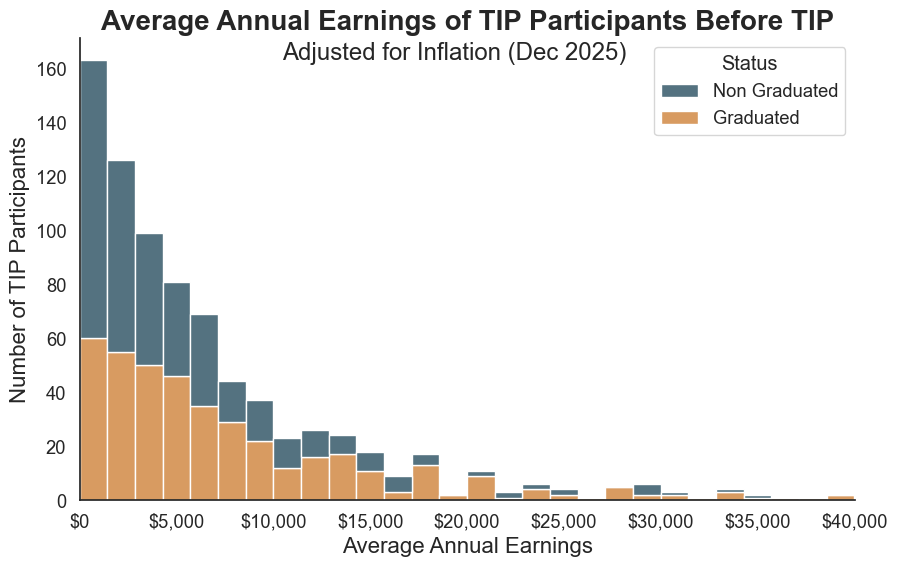

In [193]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    data=df[
        (df["Status"].isin(["Graduated", "Non Graduated"])) &
        (df["earnings_pre"] > 0) & (df["earnings_pre"] < 40000)
    ],
    x="earnings_pre",
    bins=28,
    hue="Status",
    multiple="stack"
)

sns.despine()
plt.xlim(0, 40000)
ax.xaxis.set_major_formatter('${x:,.0f}')

plt.ylabel("Number of TIP Participants", fontdict={"fontsize": 16})
plt.xlabel("Average Annual Earnings", fontdict={"fontsize": 16})
plt.title(
    "Average Annual Earnings of TIP Participants Before TIP",
    fontdict={"fontsize": 20, "fontweight": "semibold"}
)
plt.suptitle("Adjusted for Inflation (Dec 2025)", fontdict={"fontsize": 14}, y=0.875)

plt.show()

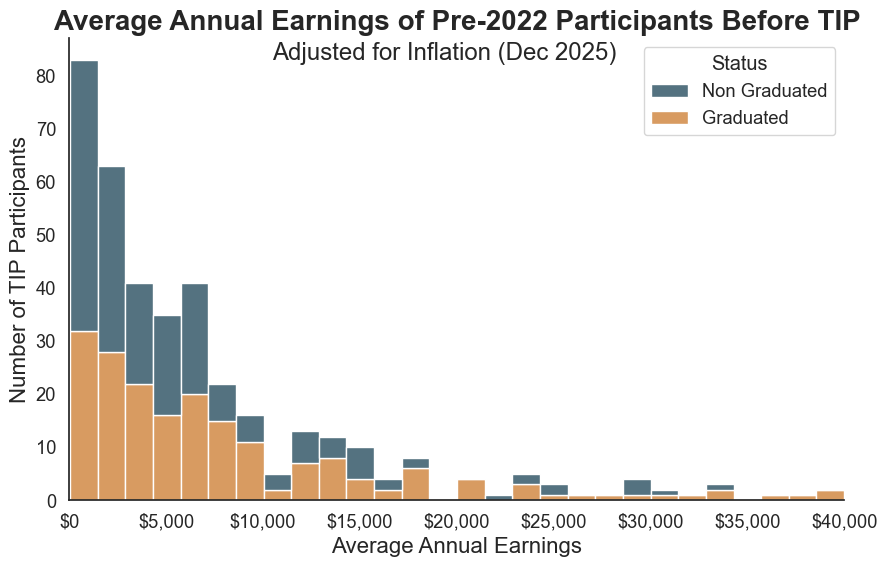

In [194]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    data=df[
        ((df["Status"].isin(["Graduated", "Non Graduated"])) & (df["cohort_2022"] == 1)) &
        (df["earnings_pre"] > 0) & (df["earnings_pre"] < 40000)
    ],
    x="earnings_pre",
    bins=28,
    hue="Status",
    multiple="stack"
)

sns.despine()
plt.xlim(0, 40000)
ax.xaxis.set_major_formatter('${x:,.0f}')

plt.ylabel("Number of TIP Participants", fontdict={"fontsize": 16})
plt.xlabel("Average Annual Earnings", fontdict={"fontsize": 16})
plt.title(
    "Average Annual Earnings of Pre-2022 Participants Before TIP",
    fontdict={"fontsize": 20, "fontweight": "semibold"}
)
plt.suptitle("Adjusted for Inflation (Dec 2025)", fontdict={"fontsize": 14}, y=0.875)

plt.show()

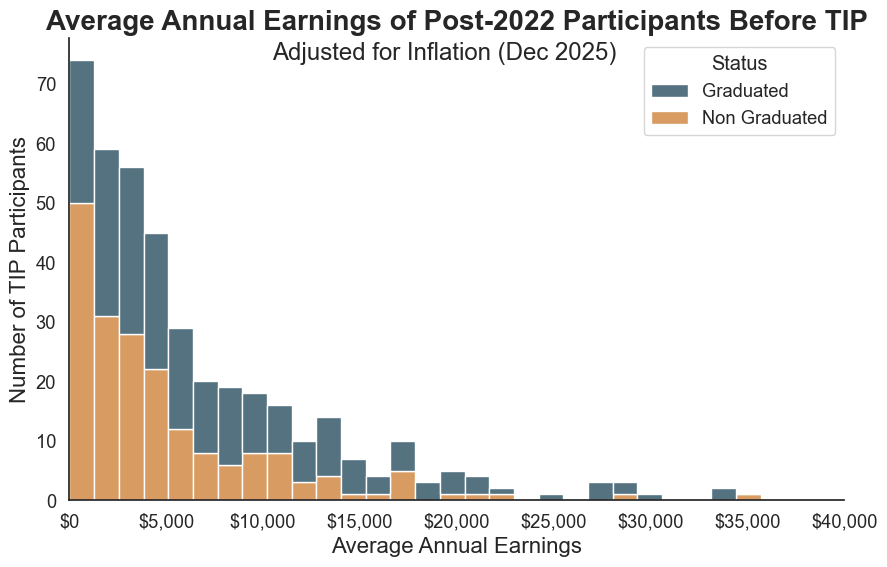

In [195]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    data=df[
        ((df["Status"].isin(["Graduated", "Non Graduated"])) & (df["cohort_2022"] == 2)) &
        (df["earnings_pre"] > 0) & (df["earnings_pre"] < 40000)
    ],
    x="earnings_pre",
    bins=28,
    hue="Status",
    multiple="stack"
)

sns.despine()
plt.xlim(0, 40000)
ax.xaxis.set_major_formatter('${x:,.0f}')

plt.ylabel("Number of TIP Participants", fontdict={"fontsize": 16})
plt.xlabel("Average Annual Earnings", fontdict={"fontsize": 16})
plt.title(
    "Average Annual Earnings of Post-2022 Participants Before TIP",
    fontdict={"fontsize": 20, "fontweight": "semibold"}
)
plt.suptitle("Adjusted for Inflation (Dec 2025)", fontdict={"fontsize": 14}, y=0.875)

plt.show()

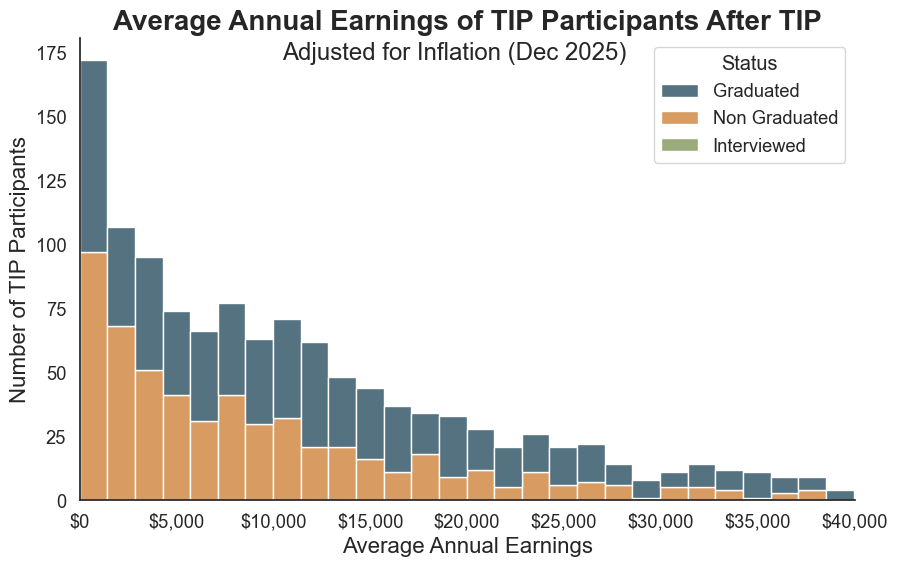

In [894]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    data=df[
        (df["Status"].isin(["Graduated", "Non Graduated"])) &
        (df["earnings_post"] > 0) & (df["earnings_post"] < 40000)
    ],
    x="earnings_post",
    bins=28,
    hue="Status",
    multiple="stack"
)

sns.despine()
plt.xlim(0, 40000)
ax.xaxis.set_major_formatter('${x:,.0f}')

plt.ylabel("Number of TIP Participants", fontdict={"fontsize": 16})
plt.xlabel("Average Annual Earnings", fontdict={"fontsize": 16})
plt.title(
    "Average Annual Earnings of TIP Participants After TIP",
    fontdict={"fontsize": 20, "fontweight": "semibold"}
)
plt.suptitle("Adjusted for Inflation (Dec 2025)", fontdict={"fontsize": 14}, y=0.875)

plt.show()

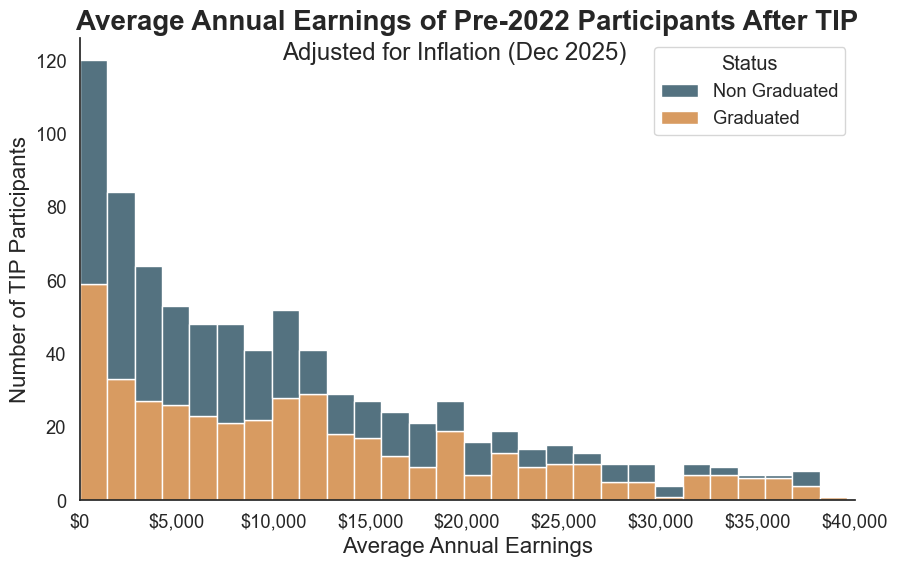

In [196]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    data=df[
        ((df["Status"].isin(["Graduated", "Non Graduated"])) & (df["cohort_2022"] == 1)) &
        (df["earnings_post"] > 0) & (df["earnings_post"] < 40000)
    ],
    x="earnings_post",
    bins=28,
    hue="Status",
    multiple="stack"
)

sns.despine()
plt.xlim(0, 40000)
ax.xaxis.set_major_formatter('${x:,.0f}')

plt.ylabel("Number of TIP Participants", fontdict={"fontsize": 16})
plt.xlabel("Average Annual Earnings", fontdict={"fontsize": 16})
plt.title(
    "Average Annual Earnings of Pre-2022 Participants After TIP",
    fontdict={"fontsize": 20, "fontweight": "semibold"}
)
plt.suptitle("Adjusted for Inflation (Dec 2025)", fontdict={"fontsize": 14}, y=0.875)

plt.show()

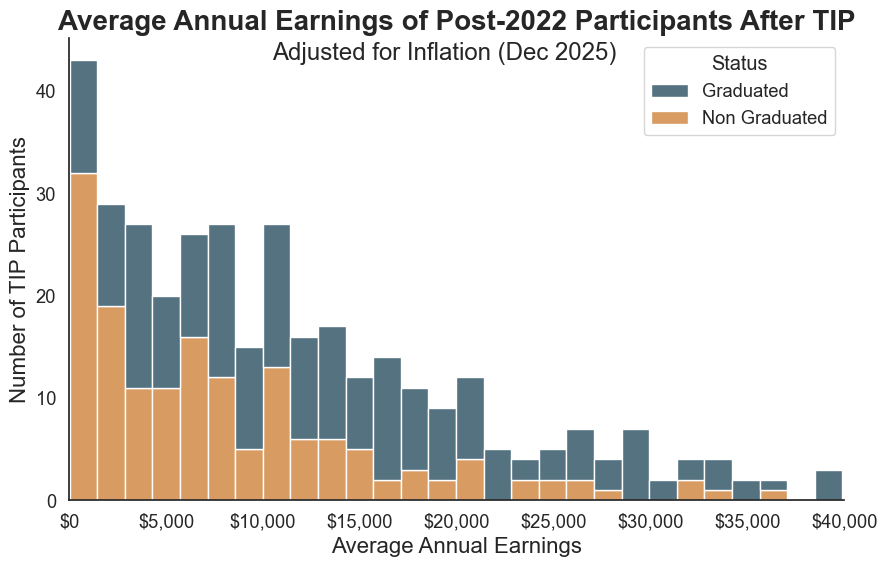

In [197]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    data=df[
        ((df["Status"].isin(["Graduated", "Non Graduated"])) & (df["cohort_2022"] == 2)) &
        (df["earnings_post"] > 0) & (df["earnings_post"] < 40000)
    ],
    x="earnings_post",
    bins=28,
    hue="Status",
    multiple="stack"
)

sns.despine()
plt.xlim(0, 40000)
ax.xaxis.set_major_formatter('${x:,.0f}')

plt.ylabel("Number of TIP Participants", fontdict={"fontsize": 16})
plt.xlabel("Average Annual Earnings", fontdict={"fontsize": 16})
plt.title(
    "Average Annual Earnings of Post-2022 Participants After TIP",
    fontdict={"fontsize": 20, "fontweight": "semibold"}
)
plt.suptitle("Adjusted for Inflation (Dec 2025)", fontdict={"fontsize": 14}, y=0.875)

plt.show()

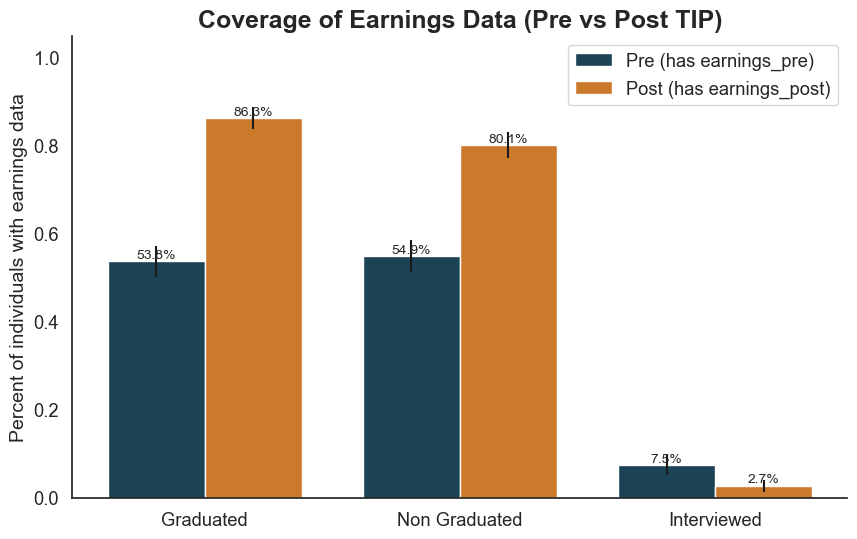

In [198]:
status_order = ["Graduated", "Non Graduated", "Interviewed"]

def has_pre(s):
    return s.notna() & (s > 0)

def has_post(s):
    return s.notna() & (s > 0)

rows = []
z = 1.96

for status in status_order:
    g = df[df["Status"] == status]

    n = g["tip_id"].nunique()

    pre_num = has_pre(pd.to_numeric(g["earnings_pre"], errors="coerce")).sum()
    post_num = has_post(pd.to_numeric(g["earnings_post"], errors="coerce")).sum()

    pre_p = pre_num / n if n > 0 else np.nan
    post_p = post_num / n if n > 0 else np.nan

    # 95% CI (normal approx)
    pre_se = np.sqrt(pre_p * (1 - pre_p) / n) if (n > 0 and pd.notna(pre_p)) else np.nan
    post_se = np.sqrt(post_p * (1 - post_p) / n) if (n > 0 and pd.notna(post_p)) else np.nan

    rows.append({
        "Status": status,
        "N": n,

        "Pre": pre_p,
        "Pre_Lower": max(0, pre_p - z * pre_se) if pd.notna(pre_se) else np.nan,
        "Pre_Upper": min(1, pre_p + z * pre_se) if pd.notna(pre_se) else np.nan,

        "Post": post_p,
        "Post_Lower": max(0, post_p - z * post_se) if pd.notna(post_se) else np.nan,
        "Post_Upper": min(1, post_p + z * post_se) if pd.notna(post_se) else np.nan,
    })

cov = pd.DataFrame(rows)
cov["Status"] = pd.Categorical(cov["Status"], categories=status_order, ordered=True)
cov = cov.sort_values("Status").reset_index(drop=True)

# ---- plot: side-by-side bars for Pre vs Post within each Status ----
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(cov))
width = 0.38

pre_err = np.abs(cov[["Pre_Upper", "Pre_Lower"]].T.values - cov["Pre"].values)
post_err = np.abs(cov[["Post_Upper", "Post_Lower"]].T.values - cov["Post"].values)

ax.bar(x - width/2, cov["Pre"], width=width, label="Pre (has earnings_pre)", yerr=pre_err, capsize=0)
ax.bar(x + width/2, cov["Post"], width=width, label="Post (has earnings_post)", yerr=post_err, capsize=0)

ax.set_xticks(x)
ax.set_xticklabels(cov["Status"], rotation=0)

for xi, p in zip(x - width/2, cov["Pre"]):
    ax.text(xi, p, f"{p:.1%}", ha="center", va="bottom", fontsize=10)
for xi, p in zip(x + width/2, cov["Post"]):
    ax.text(xi, p, f"{p:.1%}", ha="center", va="bottom", fontsize=10)

sns.despine()
plt.ylim(0, 1.05)
plt.ylabel("Percent of individuals with earnings data", fontdict={"fontsize": 14})
plt.title("Coverage of Earnings Data (Pre vs Post TIP)", fontdict={"fontsize": 18, "fontweight": "semibold"})
plt.legend()
plt.show()


In [199]:
df_earnings.columns

Index(['tip_id', 'quarter', 'employer_legal_name', 'earnings', 'naics_code',
       'naics_sector_2017', 'naics_subsector_2017', 'naics_industry_2017',
       'naics_sector_2022', 'naics_subsector_2022', 'naics_industry_2022',
       'year', 'year_quarter_dt', 'year_month', 'CPI', 'adjusted_earnings'],
      dtype='object')

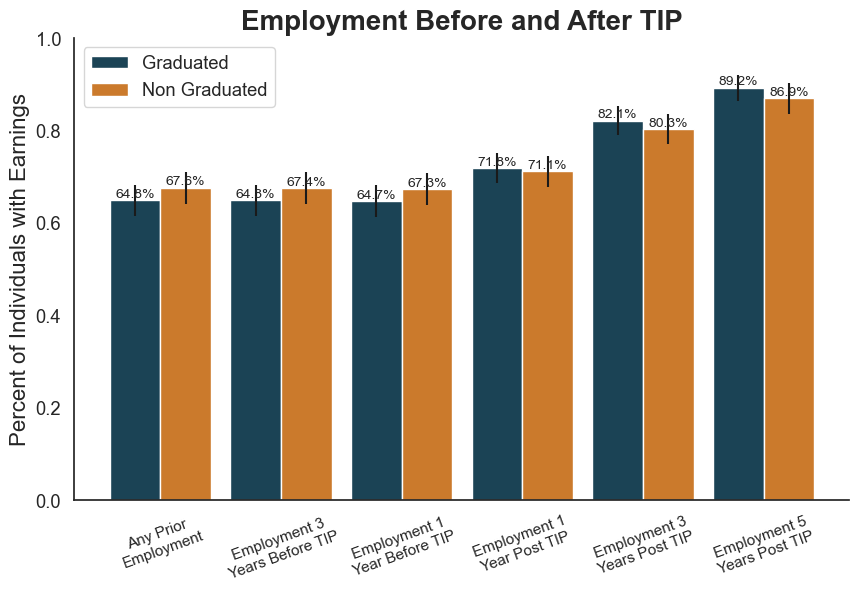

In [202]:
# -----------------------------
# 0) join Status / StartDate / ValidYears onto df_earnings
# -----------------------------
e = df_earnings.merge(
    df[["tip_id", "StartDate", "ValidYears", "Status"]],
    on="tip_id",
    how="left"
)

# keep only Graduated / Non Graduated
e = e[e["Status"].isin(["Graduated", "Non Graduated"])].copy()

# -----------------------------
# 1) YearsSinceTIP (in years) using quarter end date
# -----------------------------
e["YearsSinceTIP"] = (e["year_quarter_dt"] - e["StartDate"]).dt.days / 365.25

# "employment in quarter" indicator: has employer legal name in that quarter
e["employed_quarter"] = e["employer_legal_name"].notna() & (e["employer_legal_name"].astype(str).str.strip() != "")

# integer bin for pre buckets: >0 -> ceil, <0 -> floor, 0 -> 0
y = e["YearsSinceTIP"]
e["YearsSinceTIP_int"] = np.where(y > 0, np.ceil(y), np.where(y < 0, np.floor(y), 0)).astype(int)

# -----------------------------
# 2) PRE: bins -30, -3, -1 (cumulative)
# -----------------------------
pre_bins = {
    -1: [-1],             # 1 year pre
    -3: [-3, -2, -1],     # 1-3 years pre
    -30: list(range(-30, 0))  # any prior
}

pre = e[e["YearsSinceTIP_int"].isin(pre_bins)]

rows = []
for bin_edge, years in pre_bins.items():
    cur = e[e["YearsSinceTIP_int"].isin(years)]
    
    row = {"YearsSinceTIP": bin_edge}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        row[status] = num
        
    rows.append(row)

pre_count = pd.DataFrame(rows)

# denominators for pre: total people per status (from df)
denom_pre = (
    df[df["Status"].isin(["Graduated", "Non Graduated"])]
    .groupby("Status")["tip_id"].nunique()
    .to_dict()
)

# proportions + CI
z = 1.96
for status in ["Graduated", "Non Graduated"]:
    pre_count[f"{status} Percent"] = pre_count.get(status, 0) / denom_pre.get(status, np.nan)
    p = pre_count[f"{status} Percent"]
    n = denom_pre.get(status, np.nan)
    se = np.sqrt(p * (1 - p) / n)
    pre_count[f"{status}_Upper_CI"] = (p + z * se).clip(0, 1)
    pre_count[f"{status}_Lower_CI"] = (p - z * se).clip(0, 1)

# -----------------------------
# 3) POST: cumulative windows [0, i) for i = 1,3,5 and require ValidYears > i
# -----------------------------
post_points = [1, 3, 5]
rows = []

for i in post_points:
    cur = e[(e["YearsSinceTIP"] >= 0) & (e["YearsSinceTIP"] < i) & (e["ValidYears"] > i)]

    row = {"YearsSinceTIP": i}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        denom = df.loc[(df["Status"] == status) & (df["ValidYears"] > i), "tip_id"].nunique()

        p = (num / denom) if denom > 0 else 0
        se = np.sqrt(p * (1 - p) / denom) if denom > 0 else np.nan

        row[f"{status}"] = num
        row[f"{status} Percent"] = p
        row[f"{status}_Upper_CI"] = min(1, p + z * se) if denom > 0 else np.nan
        row[f"{status}_Lower_CI"] = max(0, p - z * se) if denom > 0 else np.nan

    rows.append(row)

post_df = pd.DataFrame(rows)

# -----------------------------
# 4) assemble 6 categories + plot
# -----------------------------
label_map = {
    -30: "Any Prior\nEmployment",
    -3:  "Employment 3\nYears Before TIP",
    -1:  "Employment 1\nYear Before TIP",
     1:  "Employment 1\nYear Post TIP",
     3:  "Employment 3\nYears Post TIP",
     5:  "Employment 5\nYears Post TIP",
}
order = [-30, -3, -1, 1, 3, 5]

pre_keep = pre_count[pre_count["YearsSinceTIP"].isin([-30, -3, -1])].copy()
data = pd.concat([pre_keep, post_df], ignore_index=True)

data["YearsSinceTIP"] = data["YearsSinceTIP"].astype(int)
data["YearsSinceTIP"] = pd.Categorical(data["YearsSinceTIP"], categories=order, ordered=True)
data = data.sort_values("YearsSinceTIP").reset_index(drop=True)
data["label"] = data["YearsSinceTIP"].astype(int).map(label_map)

grad_err = np.abs(
    data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values
)
non_grad_err = np.abs(
    data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values
)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(data))
width = 0.42

ax.bar(x - width/2, data["Graduated Percent"], width=width, label="Graduated", yerr=grad_err, capsize=0)
ax.bar(x + width/2, data["Non Graduated Percent"], width=width, label="Non Graduated", yerr=non_grad_err, capsize=0)

ax.set_xticks(x)
ax.set_xticklabels(data["label"], rotation=20, ha="center", fontsize=11)

for xi, yi in zip(x - width/2, data["Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)
for xi, yi in zip(x + width/2, data["Non Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)

sns.despine()
plt.title("Employment Before and After TIP", fontdict={"fontsize": 20, "fontweight": "semibold"})
plt.ylabel("Percent of Individuals with Earnings", fontdict={"fontsize": 16})
plt.ylim(0, 1.0)
plt.legend(loc="upper left")
plt.show()


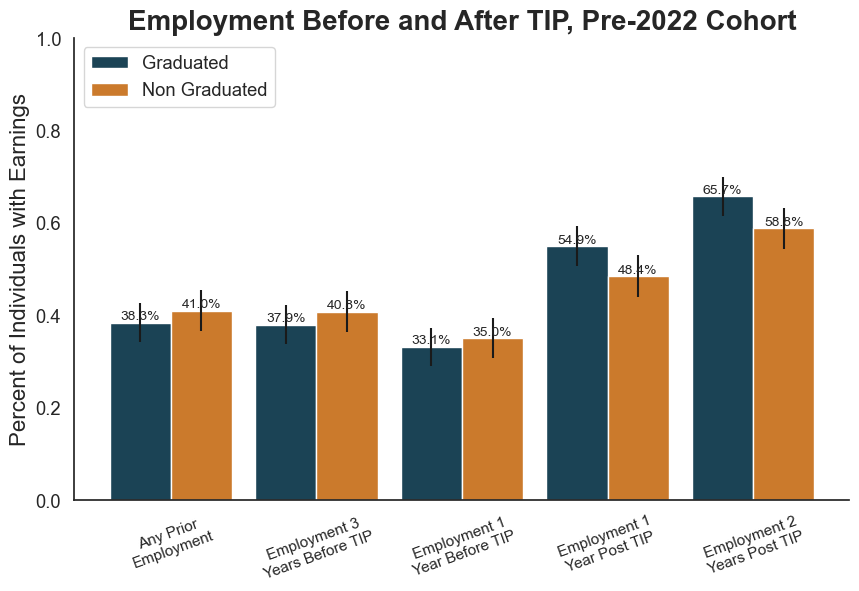

In [211]:
# -----------------------------
# 0) join Status / StartDate / ValidYears onto df_earnings
# -----------------------------
e = df_earnings.merge(
    df[["tip_id", "StartDate", "ValidYears", "Status", "cohort_2022"]],
    on="tip_id",
    how="left"
)

# keep only Graduated / Non Graduated, cohort 1
e = e[(e["Status"].isin(["Graduated", "Non Graduated"])) & (e["cohort_2022"] ==1)].copy()

# -----------------------------
# 1) YearsSinceTIP (in years) using quarter end date
# -----------------------------
e["YearsSinceTIP"] = (e["year_quarter_dt"] - e["StartDate"]).dt.days / 365.25

# "employment in quarter" indicator: has employer legal name in that quarter
e["employed_quarter"] = e["employer_legal_name"].notna() & (e["employer_legal_name"].astype(str).str.strip() != "")

# integer bin for pre buckets: >0 -> ceil, <0 -> floor, 0 -> 0
y = e["YearsSinceTIP"]
e["YearsSinceTIP_int"] = np.where(y > 0, np.ceil(y), np.where(y < 0, np.floor(y), 0)).astype(int)

# -----------------------------
# 2) PRE: bins -30, -3, -1 (cumulative)
# -----------------------------
pre_bins = {
    -1: [-1],             # 1 year pre
    -3: [-3, -2, -1],     # 1-3 years pre
    -30: list(range(-30, 0))  # any prior
}

pre = e[e["YearsSinceTIP_int"].isin(pre_bins)]

rows = []
for bin_edge, years in pre_bins.items():
    cur = e[
    (e["YearsSinceTIP_int"].isin(years)) &
    (e["employed_quarter"])]
    
    row = {"YearsSinceTIP": bin_edge}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        row[status] = num
        
    rows.append(row)

pre_count = pd.DataFrame(rows)

# denominators for pre: total people per status (from df)
denom_pre = (
    df[(df["Status"].isin(["Graduated", "Non Graduated"]))&(df["cohort_2022"]==1)]
    .groupby("Status")["tip_id"].nunique()
    .to_dict()
)

# proportions + CI
z = 1.96
for status in ["Graduated", "Non Graduated"]:
    pre_count[f"{status} Percent"] = pre_count.get(status, 0) / denom_pre.get(status, np.nan)
    p = pre_count[f"{status} Percent"]
    n = denom_pre.get(status, np.nan)
    se = np.sqrt(p * (1 - p) / n)
    pre_count[f"{status}_Upper_CI"] = (p + z * se).clip(0, 1)
    pre_count[f"{status}_Lower_CI"] = (p - z * se).clip(0, 1)

# -----------------------------
# 3) POST: cumulative windows [0, i) for i = 1,2 and require ValidYears > i
# -----------------------------
post_points = [1, 2]
rows = []

for i in post_points:
    cur = e[
    (e["YearsSinceTIP"] >= 0) &
    (e["YearsSinceTIP"] < i) &
    (e["ValidYears"] > i) &
    (e["employed_quarter"])
]

    row = {"YearsSinceTIP": i}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        denom = df.loc[(df["Status"] == status) & (df["ValidYears"] > i) & (df["cohort_2022"]==1), "tip_id"].nunique()

        p = (num / denom) if denom > 0 else 0
        se = np.sqrt(p * (1 - p) / denom) if denom > 0 else np.nan

        row[f"{status}"] = num
        row[f"{status} Percent"] = p
        row[f"{status}_Upper_CI"] = min(1, p + z * se) if denom > 0 else np.nan
        row[f"{status}_Lower_CI"] = max(0, p - z * se) if denom > 0 else np.nan

    rows.append(row)

post_df = pd.DataFrame(rows)

# -----------------------------
# 4) assemble 6 categories + plot
# -----------------------------
label_map = {
    -30: "Any Prior\nEmployment",
    -3:  "Employment 3\nYears Before TIP",
    -1:  "Employment 1\nYear Before TIP",
     1:  "Employment 1\nYear Post TIP",
     2:  "Employment 2\nYears Post TIP",
}
order = [-30, -3, -1, 1, 2]

pre_keep = pre_count[pre_count["YearsSinceTIP"].isin([-30, -3, -1])].copy()
data = pd.concat([pre_keep, post_df], ignore_index=True)

data["YearsSinceTIP"] = data["YearsSinceTIP"].astype(int)
data["YearsSinceTIP"] = pd.Categorical(data["YearsSinceTIP"], categories=order, ordered=True)
data = data.sort_values("YearsSinceTIP").reset_index(drop=True)
data["label"] = data["YearsSinceTIP"].astype(int).map(label_map)

grad_err = np.abs(
    data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values
)
non_grad_err = np.abs(
    data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values
)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(data))
width = 0.42

ax.bar(x - width/2, data["Graduated Percent"], width=width, label="Graduated", yerr=grad_err, capsize=0)
ax.bar(x + width/2, data["Non Graduated Percent"], width=width, label="Non Graduated", yerr=non_grad_err, capsize=0)

ax.set_xticks(x)
ax.set_xticklabels(data["label"], rotation=20, ha="center", fontsize=11)

for xi, yi in zip(x - width/2, data["Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)
for xi, yi in zip(x + width/2, data["Non Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)

sns.despine()
plt.title("Employment Before and After TIP, Pre-2022 Cohort", fontdict={"fontsize": 20, "fontweight": "semibold"})
plt.ylabel("Percent of Individuals with Earnings", fontdict={"fontsize": 16})
plt.ylim(0, 1.0)
plt.legend(loc="upper left")
plt.show()


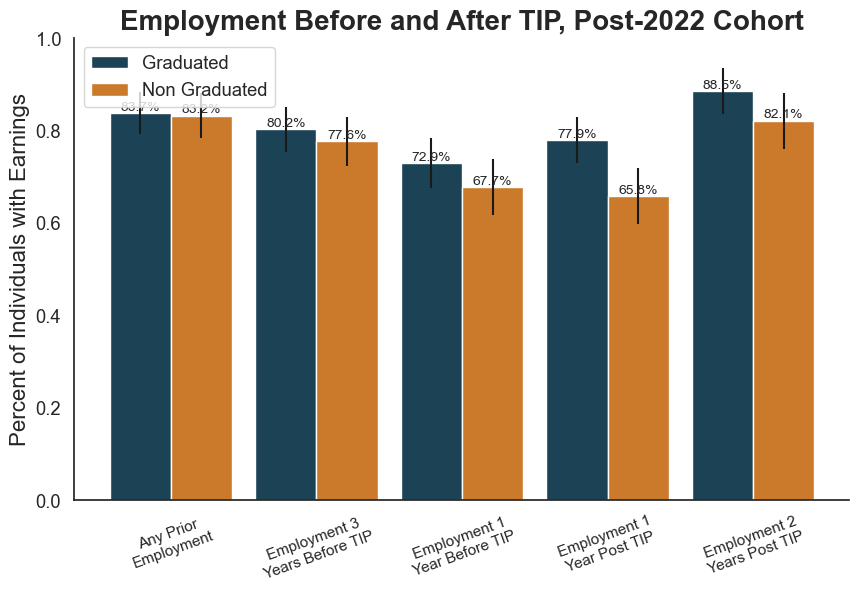

In [210]:
# -----------------------------
# COHORT 2
#0) join Status / StartDate / ValidYears onto df_earnings
# -----------------------------
e = df_earnings.merge(
    df[["tip_id", "StartDate", "ValidYears", "Status", "cohort_2022"]],
    on="tip_id",
    how="left"
)

# keep only Graduated / Non Graduated, cohort 2
e = e[(e["Status"].isin(["Graduated", "Non Graduated"])) & (e["cohort_2022"] ==2)].copy()

# -----------------------------
# 1) YearsSinceTIP (in years) using quarter end date
# -----------------------------
e["YearsSinceTIP"] = (e["year_quarter_dt"] - e["StartDate"]).dt.days / 365.25

# "employment in quarter" indicator: has employer legal name in that quarter
e["employed_quarter"] = e["employer_legal_name"].notna() & (e["employer_legal_name"].astype(str).str.strip() != "")

# integer bin for pre buckets: >0 -> ceil, <0 -> floor, 0 -> 0
y = e["YearsSinceTIP"]
e["YearsSinceTIP_int"] = np.where(y > 0, np.ceil(y), np.where(y < 0, np.floor(y), 0)).astype(int)

# -----------------------------
# 2) PRE: bins -30, -3, -1 (cumulative)
# -----------------------------
pre_bins = {
    -1: [-1],             # 1 year pre
    -3: [-3, -2, -1],     # 1-3 years pre
    -30: list(range(-30, 0))  # any prior
}

pre = e[e["YearsSinceTIP_int"].isin(pre_bins)]

rows = []
for bin_edge, years in pre_bins.items():
    cur = e[
    (e["YearsSinceTIP_int"].isin(years)) &
    (e["employed_quarter"])]
    
    row = {"YearsSinceTIP": bin_edge}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        row[status] = num
        
    rows.append(row)

pre_count = pd.DataFrame(rows)

# denominators for pre: total people per status (from df)
denom_pre = (
    df[(df["Status"].isin(["Graduated", "Non Graduated"]))&(df["cohort_2022"]==2)]
    .groupby("Status")["tip_id"].nunique()
    .to_dict()
)

# proportions + CI
z = 1.96
for status in ["Graduated", "Non Graduated"]:
    pre_count[f"{status} Percent"] = pre_count.get(status, 0) / denom_pre.get(status, np.nan)
    p = pre_count[f"{status} Percent"]
    n = denom_pre.get(status, np.nan)
    se = np.sqrt(p * (1 - p) / n)
    pre_count[f"{status}_Upper_CI"] = (p + z * se).clip(0, 1)
    pre_count[f"{status}_Lower_CI"] = (p - z * se).clip(0, 1)

# -----------------------------
# 3) POST: cumulative windows [0, i) for i = 1,2 and require ValidYears > i
# -----------------------------
post_points = [1, 2]
rows = []

for i in post_points:
    cur = e[
    (e["YearsSinceTIP"] >= 0) &
    (e["YearsSinceTIP"] < i) &
    (e["ValidYears"] > i) &
    (e["employed_quarter"])
]

    row = {"YearsSinceTIP": i}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        denom = df.loc[(df["Status"] == status) & (df["ValidYears"] > i) & (df["cohort_2022"]==2), "tip_id"].nunique()

        p = (num / denom) if denom > 0 else 0
        se = np.sqrt(p * (1 - p) / denom) if denom > 0 else np.nan

        row[f"{status}"] = num
        row[f"{status} Percent"] = p
        row[f"{status}_Upper_CI"] = min(1, p + z * se) if denom > 0 else np.nan
        row[f"{status}_Lower_CI"] = max(0, p - z * se) if denom > 0 else np.nan

    rows.append(row)

post_df = pd.DataFrame(rows)

# -----------------------------
# 4) assemble 6 categories + plot
# -----------------------------
label_map = {
    -30: "Any Prior\nEmployment",
    -3:  "Employment 3\nYears Before TIP",
    -1:  "Employment 1\nYear Before TIP",
     1:  "Employment 1\nYear Post TIP",
     2:  "Employment 2\nYears Post TIP",
}
order = [-30, -3, -1, 1, 2]

pre_keep = pre_count[pre_count["YearsSinceTIP"].isin([-30, -3, -1])].copy()
data = pd.concat([pre_keep, post_df], ignore_index=True)

data["YearsSinceTIP"] = data["YearsSinceTIP"].astype(int)
data["YearsSinceTIP"] = pd.Categorical(data["YearsSinceTIP"], categories=order, ordered=True)
data = data.sort_values("YearsSinceTIP").reset_index(drop=True)
data["label"] = data["YearsSinceTIP"].astype(int).map(label_map)

grad_err = np.abs(
    data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values
)
non_grad_err = np.abs(
    data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values
)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(data))
width = 0.42

ax.bar(x - width/2, data["Graduated Percent"], width=width, label="Graduated", yerr=grad_err, capsize=0)
ax.bar(x + width/2, data["Non Graduated Percent"], width=width, label="Non Graduated", yerr=non_grad_err, capsize=0)

ax.set_xticks(x)
ax.set_xticklabels(data["label"], rotation=20, ha="center", fontsize=11)

for xi, yi in zip(x - width/2, data["Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)
for xi, yi in zip(x + width/2, data["Non Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)

sns.despine()
plt.title("Employment Before and After TIP, Post-2022 Cohort", fontdict={"fontsize": 20, "fontweight": "semibold"})
plt.ylabel("Percent of Individuals with Earnings", fontdict={"fontsize": 16})
plt.ylim(0, 1.0)
plt.legend(loc="upper left")
plt.show()


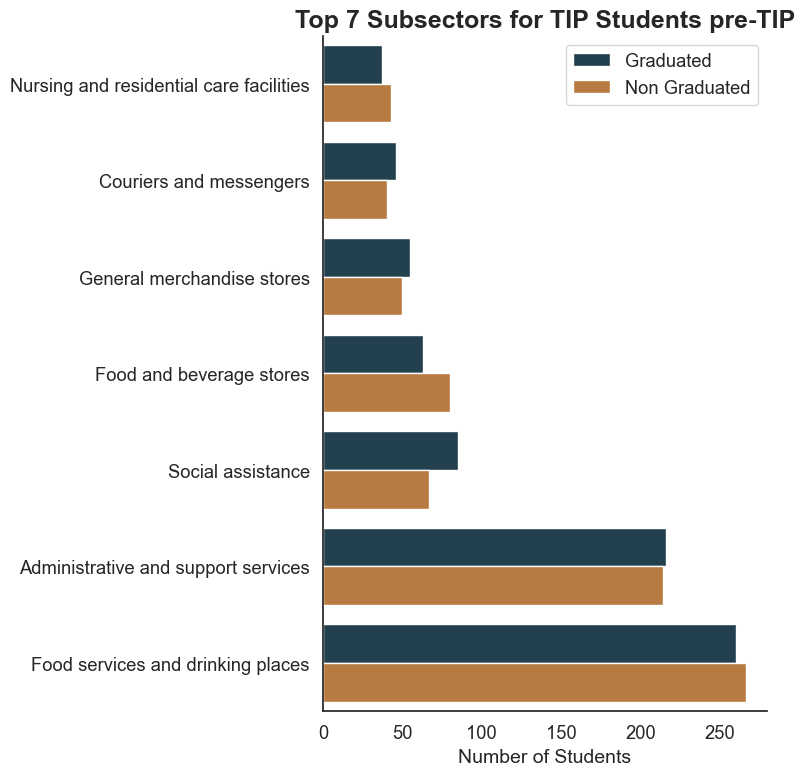

In [212]:
# 1) join StartDate + Status
e = df_earnings.merge(
    df[["tip_id", "StartDate", "Status"]],
    on="tip_id",
    how="left"
)

# 2) keep only Grad / Non Grad + pre-TIP quarters + non-missing subsector
e = e[
    e["Status"].isin(["Graduated", "Non Graduated"]) &
    (e["year_quarter_dt"] < e["StartDate"]) &
    e["naics_subsector_2017"].notna()
].copy()

# (optional) drop blank strings just in case
e = e[e["naics_subsector_2017"].astype(str).str.strip() != ""]

# 3) count unique students (tip_id) by subsector and status
counts = (
    e.groupby(["naics_subsector_2017", "Status"])["tip_id"]
    .nunique()
    .reset_index(name="count")
)

# 4) pick overall top 7 subsectors by total students (across both statuses)
top7 = (
    counts.groupby("naics_subsector_2017")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

plot_df = counts[counts["naics_subsector_2017"].isin(top7)].copy()

# order y-axis by total (top to bottom)
order = (
    plot_df.groupby("naics_subsector_2017")["count"]
    .sum()
    .sort_values(ascending=True)   # ascending so biggest ends up on top after barh
    .index
)

# 5) plot
plt.figure(figsize=(8, 8))
ax = sns.barplot(
    data=plot_df,
    y="naics_subsector_2017",
    x="count",
    hue="Status",
    order=order,
    orient="h"
)

sns.despine()
plt.title("Top 7 Subsectors for TIP Students pre-TIP", fontdict={"fontsize": 18, "fontweight": "semibold"})
plt.xlabel("Number of Students", fontdict={"fontsize": 14})
plt.ylabel("")

# make legend look like screenshot order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title=None, loc="upper right")

plt.tight_layout()
plt.show()


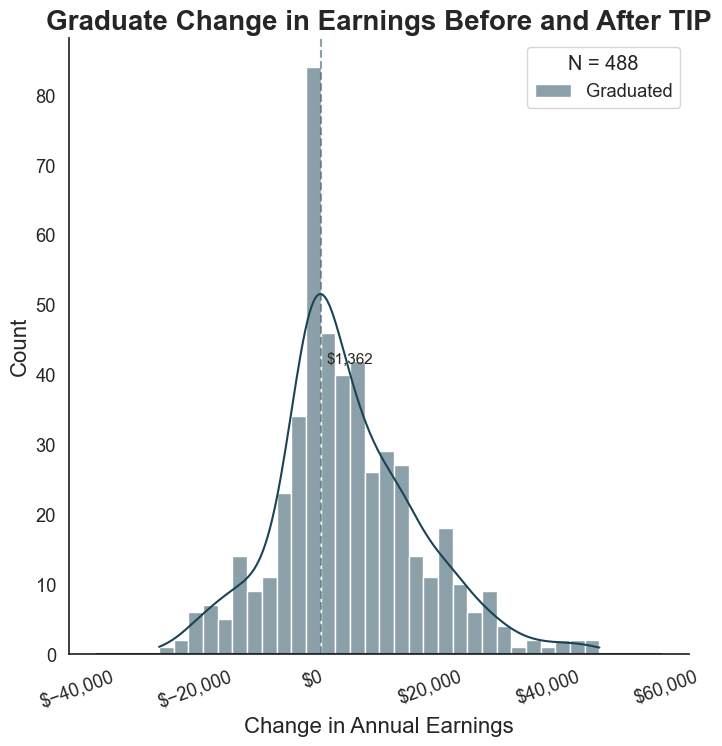

In [213]:
# 0) merge Status + StartDate onto df_earnings
earn = df_earnings.merge(
    df[["tip_id", "StartDate", "Status"]],
    on="tip_id",
    how="left"
)

# 1) split pre/post by quarter date vs StartDate
pre_tip = earn[earn["year_quarter_dt"] < earn["StartDate"]].copy()
post_tip = earn[earn["year_quarter_dt"] >= earn["StartDate"]].copy()

# 2) Graduated: annual sum -> mean across years
pre_grad = (
    pre_tip[pre_tip["Status"] == "Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_pre"})
)

post_grad = (
    post_tip[post_tip["Status"] == "Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_post"})
)

# 3) delta = post - pre (keep only people with both sides)
grad_comparison = pre_grad.merge(post_grad, on="tip_id", how="inner")
grad_comparison["delta"] = grad_comparison["adjusted_earnings_post"] - grad_comparison["adjusted_earnings_pre"]

# 4) plot
fig, ax = plt.subplots(figsize=(8, 8))

sns.histplot(
    data=grad_comparison,
    x="delta",
    kde=True,
    bins=30,
    ax=ax,
    label="Graduated"
)

# KDE peak
kde = sns.kdeplot(data=grad_comparison, x="delta", ax=ax)
x_vals, y_vals = kde.get_lines()[0].get_data()
peak_idx = y_vals.argmax()
peak_x = x_vals[peak_idx]

ax.axvline(peak_x, linestyle="--", alpha=0.5)
ax.text(
    peak_x + 5000,
    y_vals[peak_idx] * 0.8,
    f"${peak_x:,.0f}",
    ha="center",
    va="bottom",
    fontsize=11,
    fontweight="medium",
)

sns.despine()
plt.title("Graduate Change in Earnings Before and After TIP", fontdict={"fontsize": 20, "fontweight": "semibold"})
ax.xaxis.set_major_formatter("${x:,.0f}")
plt.xticks(rotation=20)
plt.xlabel("Change in Annual Earnings", fontdict={"fontsize": 16})
plt.ylabel("Count", fontdict={"fontsize": 16})
plt.legend(title=f"N = {grad_comparison.shape[0]}")
plt.show()


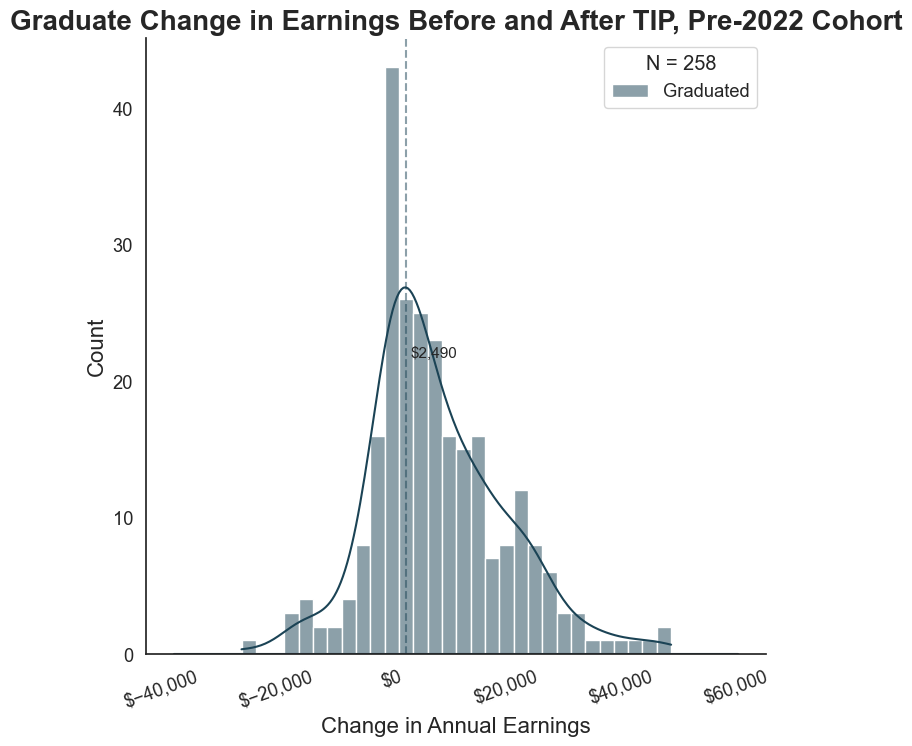

In [216]:
# 0) merge Status + StartDate onto df_earnings
earn = df_earnings.merge(
    df[["tip_id", "StartDate", "Status", "cohort_2022"]],
    on="tip_id",
    how="left"
)
earn = earn[earn["cohort_2022"]==1].copy()

# 1) split pre/post by quarter date vs StartDate
pre_tip = earn[earn["year_quarter_dt"] < earn["StartDate"]].copy()
post_tip = earn[earn["year_quarter_dt"] >= earn["StartDate"]].copy()

# 2) Graduated: annual sum -> mean across years
pre_grad = (
    pre_tip[pre_tip["Status"] == "Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_pre"})
)

post_grad = (
    post_tip[post_tip["Status"] == "Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_post"})
)

# 3) delta = post - pre (keep only people with both sides)
grad_comparison = pre_grad.merge(post_grad, on="tip_id", how="inner")
grad_comparison["delta"] = grad_comparison["adjusted_earnings_post"] - grad_comparison["adjusted_earnings_pre"]

# 4) plot
fig, ax = plt.subplots(figsize=(8, 8))

sns.histplot(
    data=grad_comparison,
    x="delta",
    kde=True,
    bins=30,
    ax=ax,
    label="Graduated"
)

# KDE peak
kde = sns.kdeplot(data=grad_comparison, x="delta", ax=ax)
x_vals, y_vals = kde.get_lines()[0].get_data()
peak_idx = y_vals.argmax()
peak_x = x_vals[peak_idx]

ax.axvline(peak_x, linestyle="--", alpha=0.5)
ax.text(
    peak_x + 5000,
    y_vals[peak_idx] * 0.8,
    f"${peak_x:,.0f}",
    ha="center",
    va="bottom",
    fontsize=11,
    fontweight="medium",
)

sns.despine()
plt.title("Graduate Change in Earnings Before and After TIP, Pre-2022 Cohort", fontdict={"fontsize": 20, "fontweight": "semibold"})
ax.xaxis.set_major_formatter("${x:,.0f}")
plt.xticks(rotation=20)
plt.xlabel("Change in Annual Earnings", fontdict={"fontsize": 16})
plt.ylabel("Count", fontdict={"fontsize": 16})
plt.legend(title=f"N = {grad_comparison.shape[0]}")
plt.show()


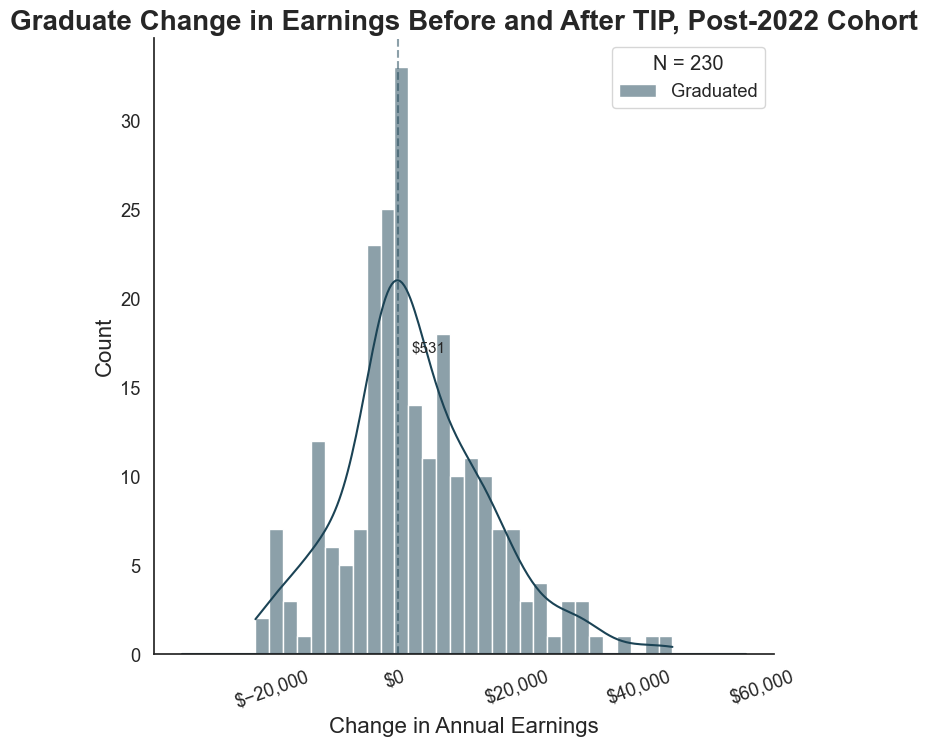

In [217]:
# 0) merge Status + StartDate onto df_earnings
earn = df_earnings.merge(
    df[["tip_id", "StartDate", "Status", "cohort_2022"]],
    on="tip_id",
    how="left"
)
earn = earn[earn["cohort_2022"]==2].copy()

# 1) split pre/post by quarter date vs StartDate
pre_tip = earn[earn["year_quarter_dt"] < earn["StartDate"]].copy()
post_tip = earn[earn["year_quarter_dt"] >= earn["StartDate"]].copy()

# 2) Graduated: annual sum -> mean across years
pre_grad = (
    pre_tip[pre_tip["Status"] == "Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_pre"})
)

post_grad = (
    post_tip[post_tip["Status"] == "Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_post"})
)

# 3) delta = post - pre (keep only people with both sides)
grad_comparison = pre_grad.merge(post_grad, on="tip_id", how="inner")
grad_comparison["delta"] = grad_comparison["adjusted_earnings_post"] - grad_comparison["adjusted_earnings_pre"]

# 4) plot
fig, ax = plt.subplots(figsize=(8, 8))

sns.histplot(
    data=grad_comparison,
    x="delta",
    kde=True,
    bins=30,
    ax=ax,
    label="Graduated"
)

# KDE peak
kde = sns.kdeplot(data=grad_comparison, x="delta", ax=ax)
x_vals, y_vals = kde.get_lines()[0].get_data()
peak_idx = y_vals.argmax()
peak_x = x_vals[peak_idx]

ax.axvline(peak_x, linestyle="--", alpha=0.5)
ax.text(
    peak_x + 5000,
    y_vals[peak_idx] * 0.8,
    f"${peak_x:,.0f}",
    ha="center",
    va="bottom",
    fontsize=11,
    fontweight="medium",
)

sns.despine()
plt.title("Graduate Change in Earnings Before and After TIP, Post-2022 Cohort", fontdict={"fontsize": 20, "fontweight": "semibold"})
ax.xaxis.set_major_formatter("${x:,.0f}")
plt.xticks(rotation=20)
plt.xlabel("Change in Annual Earnings", fontdict={"fontsize": 16})
plt.ylabel("Count", fontdict={"fontsize": 16})
plt.legend(title=f"N = {grad_comparison.shape[0]}")
plt.show()


In [214]:
grad_comparison.describe()

,tip_id,adjusted_earnings_pre,adjusted_earnings_post,delta
count,488.000000,488.000000,488.000000,488.000000
mean,1334.469262,7208.273842,13093.897390,5885.623548
std,492.253456,8930.509051,12147.844978,12040.335086
min,10.000000,0.000000,0.000000,-26068.766516
25%,896.750000,728.624508,3243.457869,-559.129753
50%,1345.000000,4081.408505,9942.757744,3954.082179
75%,1756.500000,9702.256400,19411.771003,12986.054997
max,2191.000000,51403.854538,74247.860137,48709.258897


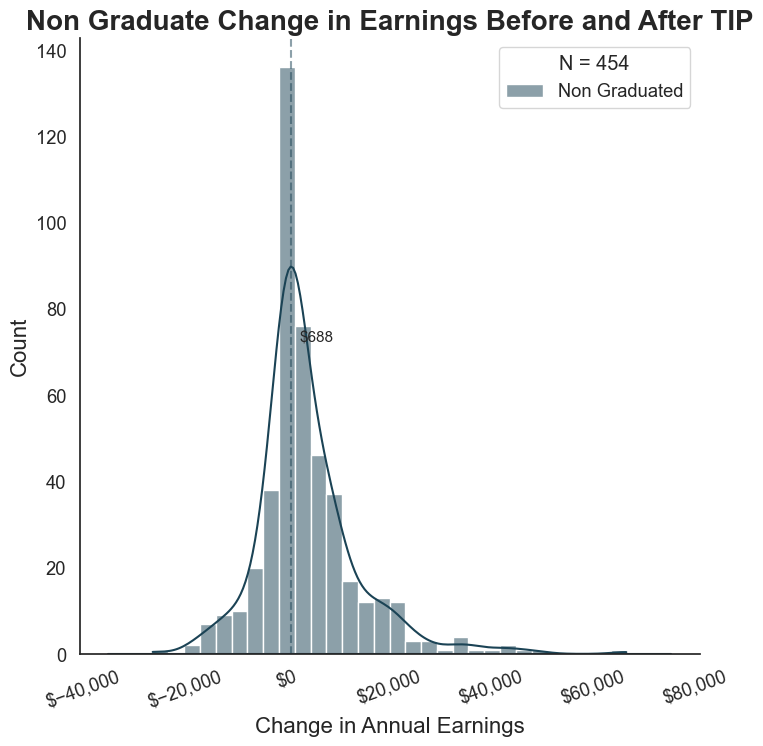

In [215]:
# 0) merge Status + StartDate onto df_earnings (if you already have earn, skip this)
earn = df_earnings.merge(
    df[["tip_id", "StartDate", "Status"]],
    on="tip_id",
    how="left"
)

# 1) split pre/post by quarter date vs StartDate
pre_tip = earn[earn["year_quarter_dt"] < earn["StartDate"]].copy()
post_tip = earn[earn["year_quarter_dt"] >= earn["StartDate"]].copy()

# 2) Non Graduated: annual sum -> mean across years
pre_non = (
    pre_tip[pre_tip["Status"] == "Non Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_pre"})
)

post_non = (
    post_tip[post_tip["Status"] == "Non Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_post"})
)

# 3) delta = post - pre (keep only people with both sides)
non_grad_comparison = pre_non.merge(post_non, on="tip_id", how="inner")
non_grad_comparison["delta"] = (
    non_grad_comparison["adjusted_earnings_post"] - non_grad_comparison["adjusted_earnings_pre"]
)

# 4) plot
fig, ax = plt.subplots(figsize=(8, 8))

sns.histplot(
    data=non_grad_comparison,
    x="delta",
    kde=True,
    bins=30,
    ax=ax,
    label="Non Graduated"
)

# KDE peak
kde = sns.kdeplot(data=non_grad_comparison, x="delta", ax=ax)
x_vals, y_vals = kde.get_lines()[0].get_data()
peak_idx = y_vals.argmax()
peak_x = x_vals[peak_idx]

ax.axvline(peak_x, linestyle="--", alpha=0.5)
ax.text(
    peak_x + 5000,
    y_vals[peak_idx] * 0.8,
    f"${peak_x:,.0f}",
    ha="center",
    va="bottom",
    fontsize=11,
    fontweight="medium",
)

sns.despine()
plt.title("Non Graduate Change in Earnings Before and After TIP", fontdict={"fontsize": 20, "fontweight": "semibold"})
ax.xaxis.set_major_formatter("${x:,.0f}")
plt.xticks(rotation=20)
plt.xlabel("Change in Annual Earnings", fontdict={"fontsize": 16})
plt.ylabel("Count", fontdict={"fontsize": 16})
plt.legend(title=f"N = {non_grad_comparison.shape[0]}")
plt.show()


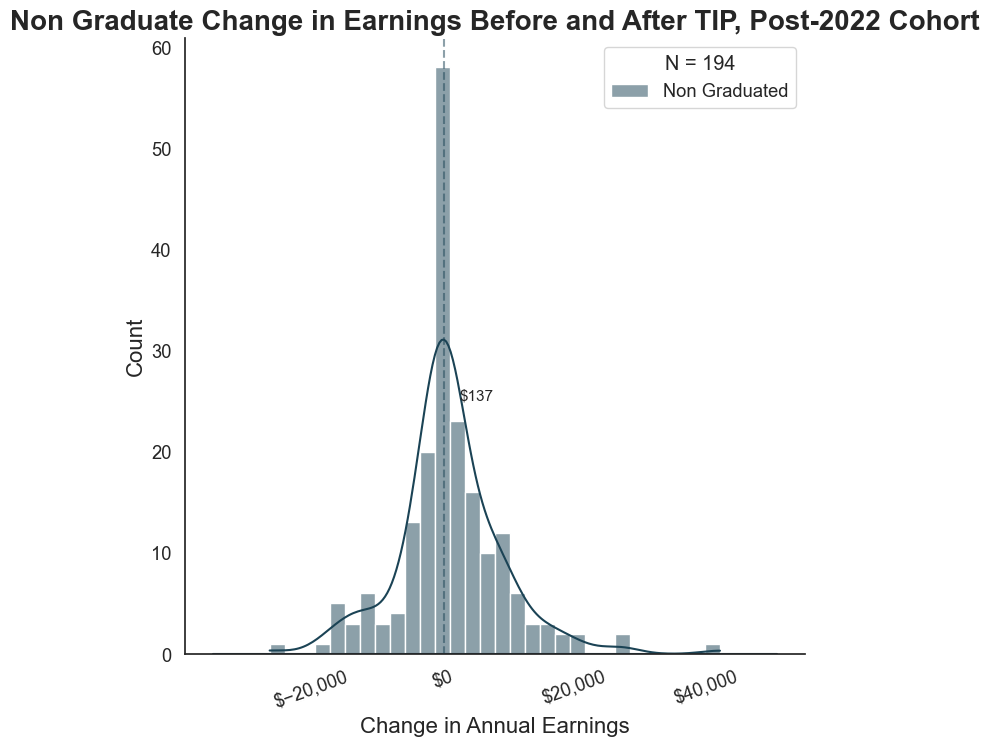

In [219]:
# 0) merge Status + StartDate onto df_earnings (if you already have earn, skip this)
earn = df_earnings.merge(
    df[["tip_id", "StartDate", "Status", "cohort_2022"]],
    on="tip_id",
    how="left"
)

earn = earn[earn["cohort_2022"]==2].copy()

# 1) split pre/post by quarter date vs StartDate
pre_tip = earn[earn["year_quarter_dt"] < earn["StartDate"]].copy()
post_tip = earn[earn["year_quarter_dt"] >= earn["StartDate"]].copy()

# 2) Non Graduated: annual sum -> mean across years
pre_non = (
    pre_tip[pre_tip["Status"] == "Non Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_pre"})
)

post_non = (
    post_tip[post_tip["Status"] == "Non Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_post"})
)

# 3) delta = post - pre (keep only people with both sides)
non_grad_comparison = pre_non.merge(post_non, on="tip_id", how="inner")
non_grad_comparison["delta"] = (
    non_grad_comparison["adjusted_earnings_post"] - non_grad_comparison["adjusted_earnings_pre"]
)

# 4) plot
fig, ax = plt.subplots(figsize=(8, 8))

sns.histplot(
    data=non_grad_comparison,
    x="delta",
    kde=True,
    bins=30,
    ax=ax,
    label="Non Graduated"
)

# KDE peak
kde = sns.kdeplot(data=non_grad_comparison, x="delta", ax=ax)
x_vals, y_vals = kde.get_lines()[0].get_data()
peak_idx = y_vals.argmax()
peak_x = x_vals[peak_idx]

ax.axvline(peak_x, linestyle="--", alpha=0.5)
ax.text(
    peak_x + 5000,
    y_vals[peak_idx] * 0.8,
    f"${peak_x:,.0f}",
    ha="center",
    va="bottom",
    fontsize=11,
    fontweight="medium",
)

sns.despine()
plt.title("Non Graduate Change in Earnings Before and After TIP, Post-2022 Cohort", fontdict={"fontsize": 20, "fontweight": "semibold"})
ax.xaxis.set_major_formatter("${x:,.0f}")
plt.xticks(rotation=20)
plt.xlabel("Change in Annual Earnings", fontdict={"fontsize": 16})
plt.ylabel("Count", fontdict={"fontsize": 16})
plt.legend(title=f"N = {non_grad_comparison.shape[0]}")
plt.show()


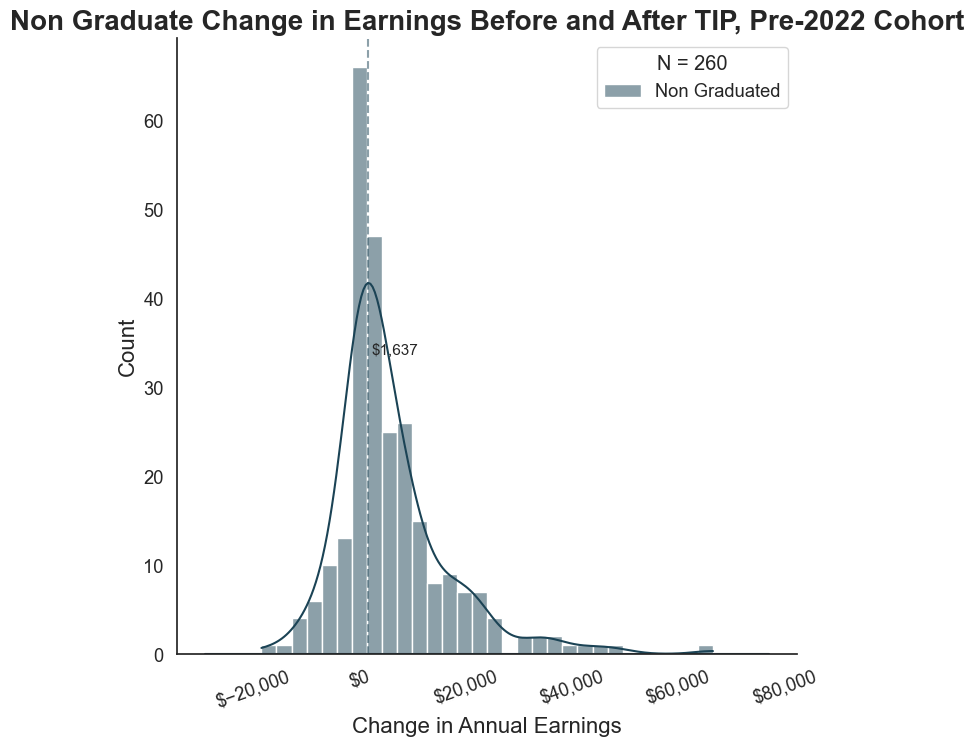

In [220]:
# 0) merge Status + StartDate onto df_earnings (if you already have earn, skip this)
earn = df_earnings.merge(
    df[["tip_id", "StartDate", "Status", "cohort_2022"]],
    on="tip_id",
    how="left"
)

earn = earn[earn["cohort_2022"]==1].copy()

# 1) split pre/post by quarter date vs StartDate
pre_tip = earn[earn["year_quarter_dt"] < earn["StartDate"]].copy()
post_tip = earn[earn["year_quarter_dt"] >= earn["StartDate"]].copy()

# 2) Non Graduated: annual sum -> mean across years
pre_non = (
    pre_tip[pre_tip["Status"] == "Non Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_pre"})
)

post_non = (
    post_tip[post_tip["Status"] == "Non Graduated"]
    .groupby(["tip_id", "year"])["adjusted_earnings"].sum()
    .reset_index()
    .groupby("tip_id")["adjusted_earnings"].mean()
    .reset_index()
    .rename(columns={"adjusted_earnings": "adjusted_earnings_post"})
)

# 3) delta = post - pre (keep only people with both sides)
non_grad_comparison = pre_non.merge(post_non, on="tip_id", how="inner")
non_grad_comparison["delta"] = (
    non_grad_comparison["adjusted_earnings_post"] - non_grad_comparison["adjusted_earnings_pre"]
)

# 4) plot
fig, ax = plt.subplots(figsize=(8, 8))

sns.histplot(
    data=non_grad_comparison,
    x="delta",
    kde=True,
    bins=30,
    ax=ax,
    label="Non Graduated"
)

# KDE peak
kde = sns.kdeplot(data=non_grad_comparison, x="delta", ax=ax)
x_vals, y_vals = kde.get_lines()[0].get_data()
peak_idx = y_vals.argmax()
peak_x = x_vals[peak_idx]

ax.axvline(peak_x, linestyle="--", alpha=0.5)
ax.text(
    peak_x + 5000,
    y_vals[peak_idx] * 0.8,
    f"${peak_x:,.0f}",
    ha="center",
    va="bottom",
    fontsize=11,
    fontweight="medium",
)

sns.despine()
plt.title("Non Graduate Change in Earnings Before and After TIP, Pre-2022 Cohort", fontdict={"fontsize": 20, "fontweight": "semibold"})
ax.xaxis.set_major_formatter("${x:,.0f}")
plt.xticks(rotation=20)
plt.xlabel("Change in Annual Earnings", fontdict={"fontsize": 16})
plt.ylabel("Count", fontdict={"fontsize": 16})
plt.legend(title=f"N = {non_grad_comparison.shape[0]}")
plt.show()


In [903]:
non_grad_comparison.describe()

,tip_id,adjusted_earnings_pre,adjusted_earnings_post,delta
count,473.000000,473.000000,473.000000,473.000000
mean,1336.329810,5201.544745,9025.671400,3824.126655
std,484.214191,8005.508430,12449.345488,9796.357824
min,1.000000,0.000000,0.000000,-19541.869471
25%,970.000000,337.094534,740.105145,-730.781156
50%,1339.000000,2310.724159,4605.430145,1292.339455
75%,1682.000000,6919.847164,11971.841381,7290.259426
max,2269.000000,79441.863951,130842.556738,66555.612829


## Data Cleaning of tip_cohort_uibenefits and Social Service Usage

In [92]:
df_uibenefits = pd.read_csv(r'C:\Users\sarah\Documents\CMU\Spring 2026\Systems Synthesis\Data\Post-Cleaning\tip_ui.csv')

In [93]:
df_uibenefits.head()

,Unnamed: 0,TIP_ID,REQUEST_PERIOD,UC_BENEFIT
0,1,1189,20173,2496.0
1,2,297,20173,1648.0
2,3,663,20172,484.0
3,4,34,20172,1281.0
4,5,129,20172,2320.0


In [94]:
# 1) rename TIP_ID -> tip_id
df_uibenefits = df_uibenefits.rename(columns={"TIP_ID": "tip_id"})

# 2) create quarter (numeric) from REQUEST_PERIOD
#    REQUEST_PERIOD should look like 20181, 20174, etc.
df_uibenefits["quarter"] = pd.to_numeric(df_uibenefits["REQUEST_PERIOD"], errors="coerce")

# 3) split quarter into q_num and year
df_uibenefits["q_num"] = (df_uibenefits["quarter"] % 10).astype("Int64")
df_uibenefits["year"] = (df_uibenefits["quarter"] // 10).astype("Int64")

# 4) ui_dummy: if UC_BENEFIT not missing -> 1 else 0
df_uibenefits["ui_dummy"] = (~df_uibenefits["UC_BENEFIT"].isna()).astype(int)

# 5) annualize: if any quarter in that year has ui_dummy==1 -> employed that year for UI receipt
df_ui_annual = (
    df_uibenefits.groupby(["tip_id", "year"], as_index=False)["ui_dummy"]
    .max()
)

In [107]:
df_ui_annual.head()

,tip_id,year,ui_dummy
0,1,2017,0
1,1,2018,0
2,1,2019,0
3,1,2020,0
4,1,2021,0


In [108]:
df_services = pd.read_csv(r'C:\Users\sarah\Documents\CMU\Spring 2026\Systems Synthesis\Data\Post-Cleaning\tip_ss.csv')
df_services = pd.merge(
    df_services,
    df[['tip_id', 'Status', 'StartDate', 'InterviewedDate', 'EndDate', 'GraduatedDate', 'ValidYears']],
    on='tip_id',
    how='left'
)

df_services['DOF'] = pd.to_datetime(df_services['year'], format='%Y')
df_services['YearsSinceTIP'] = df_services.apply(years_since_TIP, axis=1)

In [109]:
df_services.head()

,Unnamed: 0,tip_id,year,aging,drug_alcohol,mental_health,cyf_child,cyf_parent,family_support_center,early_childhood,...,ssi,ccdf,Status,StartDate,InterviewedDate,EndDate,GraduatedDate,ValidYears,DOF,YearsSinceTIP
0,1,632,2011,0,0,0,0,0,0,0,...,0,0,Non Graduated,2017-10-09,NaT,2017-12-07,NaT,8.188912,2011-01-01,-6.770844
1,2,632,2012,0,0,0,0,0,0,0,...,0,0,Non Graduated,2017-10-09,NaT,2017-12-07,NaT,8.188912,2012-01-01,-5.771508
2,3,632,2013,0,0,0,0,0,0,0,...,0,0,Non Graduated,2017-10-09,NaT,2017-12-07,NaT,8.188912,2013-01-01,-4.769434
3,4,632,2014,0,0,0,0,0,0,0,...,0,0,Non Graduated,2017-10-09,NaT,2017-12-07,NaT,8.188912,2014-01-01,-3.770098
4,5,632,2015,0,0,0,0,0,0,0,...,0,0,Non Graduated,2017-10-09,NaT,2017-12-07,NaT,8.188912,2015-01-01,-2.770762


In [110]:
df.columns

Index(['tip_id', 'GraduatedDate', 'InterviewedDate', 'StartDate', 'EndDate',
       'DriversLicense', 'Course', 'CreatedDate', 'Status', 'age',
       'cohort_2022', 'StartYear', 'census_tract', 'gender', 'race',
       'ValidYears'],
      dtype='object')

In [111]:
df_services = pd.merge(
    df_services,
    df_student[['tip_id', 'cohort_2022']],
    on='tip_id',
    how='left'
)
df_services['cohort_2022'] = pd.to_numeric(df_services['cohort_2022'], errors='coerce')


In [112]:
df_services.head

<bound method NDFrame.head of        Unnamed: 0  tip_id  year  aging  drug_alcohol  mental_health  \
0               1     632  2011      0             0              0   
1               2     632  2012      0             0              0   
2               3     632  2013      0             0              0   
3               4     632  2014      0             0              0   
4               5     632  2015      0             0              0   
...           ...     ...   ...    ...           ...            ...   
27488       27489    2187  2019      0             0              0   
27489       27490    2187  2020      0             0              0   
27490       27491    2187  2021      0             0              0   
27491       27492    2187  2022      0             0              0   
27492       27493    2187  2023      0             0              0   

       cyf_child  cyf_parent  family_support_center  early_childhood  ...  \
0              0           0            

In [113]:
# 1) year -> numeric
# -------------------------
df_services["year"] = pd.to_numeric(df_services["year"], errors="coerce")

# -------------------------
# 2) SNAP_TANF = snap + tanf
#    (treat NaN as 0 so 1+NaN -> 1 rather than NaN)
# -------------------------
df_services["SNAP_TANF"] = df_services["snap"].fillna(0) + df_services["tanf"].fillna(0)

# -------------------------
# 3) Join annual UI benefits data by tip_id, year
#    Assumes you have a df_ui_annual with columns: tip_id, year, ui (0/1) or ui_amount
# -------------------------
df_services = df_services.merge(
    df_ui_annual,   # <-- change this variable name if yours is different
    on=["tip_id", "year"],
    how="left"
)

# -------------------------
# 4) Join StartYear + Participant_Type from TIP_df and compute distance_from_TIP
#    distance_from_TIP = year - StartYear
# -------------------------
df_services = df_services.merge(
    df[["tip_id", "StartYear"]],
    on="tip_id",
    how="left"
)

df_services["distance_from_TIP"] = df_services["year"] - df_services["StartYear"]

# -------------------------
# 5) any_one: received ANY listed service that year
#    treat NaN as 0; "==1" rule per your spec
# -------------------------
service_cols = [
    "aging",
    "drug_alcohol",
    "mental_health",
    "family_support_center",
    "early_childhood",
    "jail_collab",
    "matp",
    "home_visiting",
    "dhs_housing_supports",
    "indep_living",
    "intellectual_disab",
    "link_referral",
    "public_housing",
    "section8_housing",
    "medicaid",
    "snap",
    "tanf",
    "ssi",
    "ccdf",
]

# coerce to numeric (in case of strings), fill NaN with 0
svc_mat = df_services[service_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

df_services["any_one"] = (svc_mat.eq(1).any(axis=1)).astype(int)

# -------------------------
# 6) any_one_plus_ui: include UI receipt as well
#    Pick the UI indicator column name after merge.
#    - If your df_ui_annual column is called "ui", this will work as-is.
#    - Otherwise change ui_col below to your actual column name.
# -------------------------
ui_col = "ui_dummy"  # <-- change if needed (e.g., "ui_receipt", "received_ui", etc.)

df_services[ui_col] = pd.to_numeric(df_services[ui_col], errors="coerce").fillna(0)
df_services["any_one_plus_ui"] = ((df_services["any_one"] == 1) | (df_services[ui_col] == 1)).astype(int)


In [114]:
df_services = df_services.drop(columns=["Unnamed: 0"], errors="ignore")
df_services.head()

,tip_id,year,aging,drug_alcohol,mental_health,cyf_child,cyf_parent,family_support_center,early_childhood,jail_collab,...,ValidYears,DOF,YearsSinceTIP,cohort_2022,SNAP_TANF,ui_dummy,StartYear,distance_from_TIP,any_one,any_one_plus_ui
0,632,2011,0,0,0,0,0,0,0,0,...,8.188912,2011-01-01,-6.770844,1.0,0,0.0,2017.0,-6.0,1,1
1,632,2012,0,0,0,0,0,0,0,0,...,8.188912,2012-01-01,-5.771508,1.0,0,0.0,2017.0,-5.0,1,1
2,632,2013,0,0,0,0,0,0,0,0,...,8.188912,2013-01-01,-4.769434,1.0,0,0.0,2017.0,-4.0,1,1
3,632,2014,0,0,0,0,0,0,0,0,...,8.188912,2014-01-01,-3.770098,1.0,0,0.0,2017.0,-3.0,1,1
4,632,2015,0,0,0,0,0,0,0,0,...,8.188912,2015-01-01,-2.770762,1.0,0,0.0,2017.0,-2.0,1,1


In [115]:
df_services.columns

Index(['tip_id', 'year', 'aging', 'drug_alcohol', 'mental_health', 'cyf_child',
       'cyf_parent', 'family_support_center', 'early_childhood', 'jail_collab',
       'matp', 'home_visiting', 'dhs_housing_supports', 'indep_living',
       'intellectual_disab', 'cyf_referral', 'link_referral', 'public_housing',
       'section8_housing', 'courts', 'medicaid', 'jail', 'snap', 'tanf', 'ssi',
       'ccdf', 'Status', 'StartDate', 'InterviewedDate', 'EndDate',
       'GraduatedDate', 'ValidYears', 'DOF', 'YearsSinceTIP', 'cohort_2022',
       'SNAP_TANF', 'ui_dummy', 'StartYear', 'distance_from_TIP', 'any_one',
       'any_one_plus_ui'],
      dtype='object')

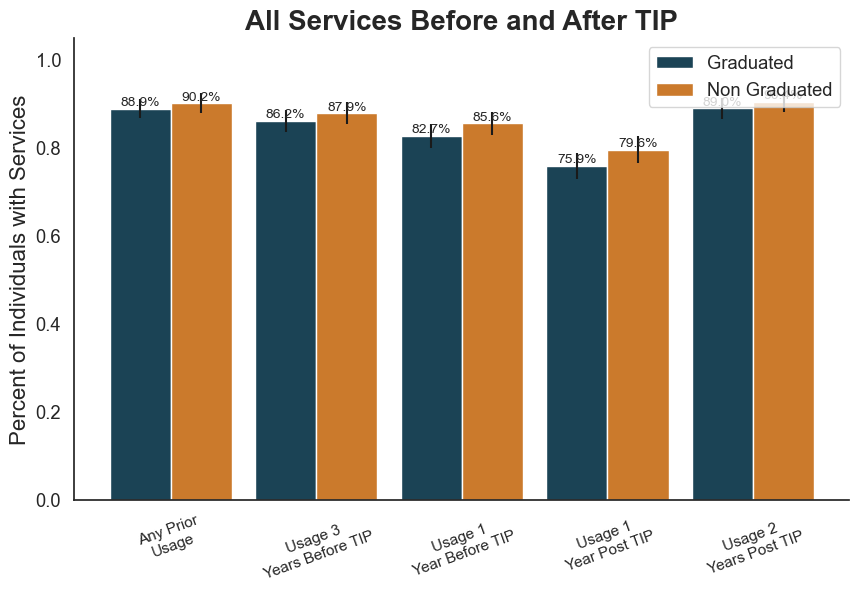

In [130]:
# ================
# CONFIG FOR FULL (COHORT 1+2)
# ================

# keep only Graduated / Non Graduated
svc = df_services.copy()
svc = svc[svc["Status"].isin(["Graduated", "Non Graduated"])].copy()

# -----------------------------
# 1) PRE cumulative bins
# -----------------------------

pre_bins = {
    -1: [-1],             # 1 year pre
    -3: [-3, -2, -1],     # 1-3 years pre
    -30: list(range(-30, 0))  # any prior usage
}

svc["YearsSinceTIP_int"] = svc["YearsSinceTIP"].round().astype(int)

rows = []
for bin_edge, years in pre_bins.items():
    cur = svc[svc["YearsSinceTIP_int"].isin(years)]
    
    row = {"YearsSinceTIP": bin_edge}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        row[status] = num
        
    rows.append(row)

pre_count = pd.DataFrame(rows)

# denominators for pre: total people per status

denom_pre = (
    df[(df["Status"].isin(["Graduated", "Non Graduated"]))]
    .groupby("Status")["tip_id"]
    .nunique()
    .to_dict()
)

z = 1.96
for status in ["Graduated", "Non Graduated"]:
    pre_count[f"{status} Percent"] = pre_count[status] / denom_pre.get(status, np.nan)
    p = pre_count[f"{status} Percent"]
    n = denom_pre.get(status, np.nan)
    se = np.sqrt(p * (1 - p) / n)
    pre_count[f"{status}_Upper_CI"] = (p + z * se).clip(0, 1)
    pre_count[f"{status}_Lower_CI"] = (p - z * se).clip(0, 1)

# -----------------------------
# 3) POST: cumulative windows [0, i) for i = 1,2 and require ValidYears > i
# -----------------------------
post_points = [1, 2]
rows = []

for i in post_points:
    cur = svc[(svc["YearsSinceTIP"] >= 0) & (svc["YearsSinceTIP"] < i+1) & (svc["ValidYears"] >= i)]

    row = {"YearsSinceTIP": i}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        denom = df.loc[(df["Status"] == status) & (df["ValidYears"] >= i), "tip_id"].nunique()

        p = (num / denom) if denom > 0 else 0
        se = np.sqrt(p * (1 - p) / denom) if denom > 0 else np.nan

        row[f"{status}"] = num
        row[f"{status} Percent"] = p
        row[f"{status}_Upper_CI"] = min(1, p + z * se) if denom > 0 else np.nan
        row[f"{status}_Lower_CI"] = max(0, p - z * se) if denom > 0 else np.nan

    rows.append(row)

post_df = pd.DataFrame(rows)

# -----------------------------
# 4) assemble 6 categories + plot
# -----------------------------
label_map = {
    -30: "Any Prior\nUsage",
    -3:  "Usage 3\nYears Before TIP",
    -1:  "Usage 1\nYear Before TIP",
     1:  "Usage 1\nYear Post TIP",
     2:  "Usage 2\nYears Post TIP"
}
order = [-30, -3, -1, 1, 2]

pre_keep = pre_count[pre_count["YearsSinceTIP"].isin([-30, -3, -1])].copy()
data = pd.concat([pre_keep, post_df], ignore_index=True)

data["YearsSinceTIP"] = data["YearsSinceTIP"].astype(int)
data["YearsSinceTIP"] = pd.Categorical(data["YearsSinceTIP"], categories=order, ordered=True)
data = data.sort_values("YearsSinceTIP").reset_index(drop=True)
data["label"] = data["YearsSinceTIP"].astype(int).map(label_map)

grad_err = np.abs(
    data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values
)
non_grad_err = np.abs(
    data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values
)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(data))
width = 0.42

ax.bar(x - width/2, data["Graduated Percent"], width=width, label="Graduated", yerr=grad_err, capsize=0)
ax.bar(x + width/2, data["Non Graduated Percent"], width=width, label="Non Graduated", yerr=non_grad_err, capsize=0)

ax.set_xticks(x)
ax.set_xticklabels(data["label"], rotation=20, ha="center", fontsize=11)

for xi, yi in zip(x - width/2, data["Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)
for xi, yi in zip(x + width/2, data["Non Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)

sns.despine()
plt.title("All Services Before and After TIP", fontdict={"fontsize": 20, "fontweight": "semibold"})
plt.ylabel("Percent of Individuals with Services", fontdict={"fontsize": 16})
plt.ylim(0, 1.05)
plt.legend(loc="upper right")
plt.show()


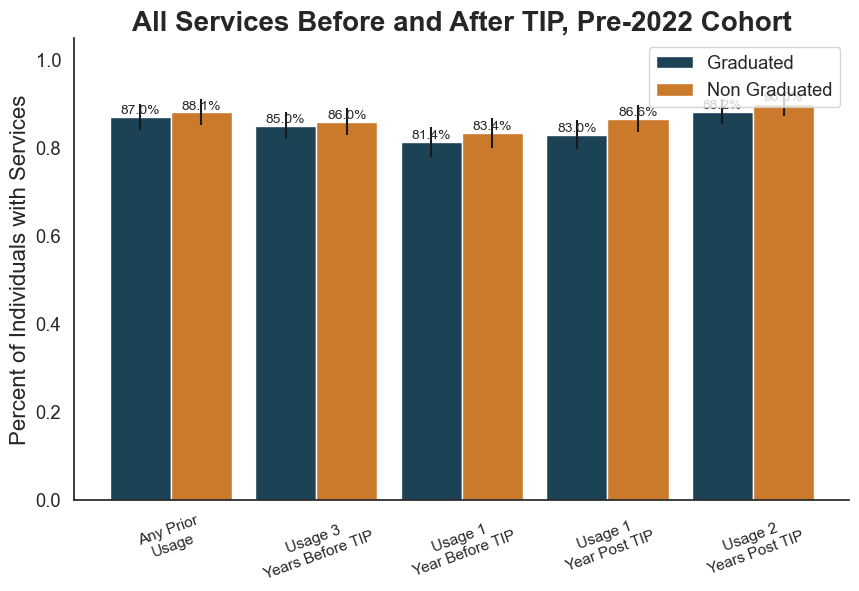

In [125]:
# ================
# CONFIG FOR COHORT 1
# ================

# keep only Graduated / Non Graduated
svc_c1 = df_services.copy()
svc_c1 = svc_c1[svc_c1["Status"].isin(["Graduated", "Non Graduated"])].copy()
svc_c1 = svc_c1[svc_c1["cohort_2022"] == 1].copy()

# -----------------------------
# 1) PRE cumulative bins
# -----------------------------

pre_bins = {
    -1: [-1],             # 1 year pre
    -3: [-3, -2, -1],     # 1-3 years pre
    -30: list(range(-30, 0))  # any prior usage
}

svc_c1["YearsSinceTIP_int"] = svc_c1["YearsSinceTIP"].round().astype(int)

rows = []
for bin_edge, years in pre_bins.items():
    cur = svc_c1[svc_c1["YearsSinceTIP_int"].isin(years)]
    
    row = {"YearsSinceTIP": bin_edge}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        row[status] = num
        
    rows.append(row)

pre_count = pd.DataFrame(rows)

# denominators for pre: total people per status

denom_pre = (
    df[(df["Status"].isin(["Graduated", "Non Graduated"])) & (df["cohort_2022"] == 1)]
    .groupby("Status")["tip_id"]
    .nunique()
    .to_dict()
)

z = 1.96
for status in ["Graduated", "Non Graduated"]:
    pre_count[f"{status} Percent"] = pre_count[status] / denom_pre.get(status, np.nan)
    p = pre_count[f"{status} Percent"]
    n = denom_pre.get(status, np.nan)
    se = np.sqrt(p * (1 - p) / n)
    pre_count[f"{status}_Upper_CI"] = (p + z * se).clip(0, 1)
    pre_count[f"{status}_Lower_CI"] = (p - z * se).clip(0, 1)

# -----------------------------
# 3) POST: cumulative windows [0, i) for i = 1,2 and require ValidYears > i
# -----------------------------
post_points = [1, 2]
rows = []

for i in post_points:
    cur = svc_c1[(svc_c1["YearsSinceTIP"] >= 0) & (svc_c1["YearsSinceTIP"] < i) & (svc_c1["ValidYears"] > i)]

    row = {"YearsSinceTIP": i}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        denom = df.loc[(df["Status"] == status) & (df["ValidYears"] > i) & (df["cohort_2022"] ==1), "tip_id"].nunique()

        p = (num / denom) if denom > 0 else 0
        se = np.sqrt(p * (1 - p) / denom) if denom > 0 else np.nan

        row[f"{status}"] = num
        row[f"{status} Percent"] = p
        row[f"{status}_Upper_CI"] = min(1, p + z * se) if denom > 0 else np.nan
        row[f"{status}_Lower_CI"] = max(0, p - z * se) if denom > 0 else np.nan

    rows.append(row)

post_df = pd.DataFrame(rows)

# -----------------------------
# 4) assemble 6 categories + plot
# -----------------------------
label_map = {
    -30: "Any Prior\nUsage",
    -3:  "Usage 3\nYears Before TIP",
    -1:  "Usage 1\nYear Before TIP",
     1:  "Usage 1\nYear Post TIP",
     2:  "Usage 2\nYears Post TIP"
}
order = [-30, -3, -1, 1, 2]

pre_keep = pre_count[pre_count["YearsSinceTIP"].isin([-30, -3, -1])].copy()
data = pd.concat([pre_keep, post_df], ignore_index=True)

data["YearsSinceTIP"] = data["YearsSinceTIP"].astype(int)
data["YearsSinceTIP"] = pd.Categorical(data["YearsSinceTIP"], categories=order, ordered=True)
data = data.sort_values("YearsSinceTIP").reset_index(drop=True)
data["label"] = data["YearsSinceTIP"].astype(int).map(label_map)

grad_err = np.abs(
    data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values
)
non_grad_err = np.abs(
    data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values
)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(data))
width = 0.42

ax.bar(x - width/2, data["Graduated Percent"], width=width, label="Graduated", yerr=grad_err, capsize=0)
ax.bar(x + width/2, data["Non Graduated Percent"], width=width, label="Non Graduated", yerr=non_grad_err, capsize=0)

ax.set_xticks(x)
ax.set_xticklabels(data["label"], rotation=20, ha="center", fontsize=11)

for xi, yi in zip(x - width/2, data["Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)
for xi, yi in zip(x + width/2, data["Non Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)

sns.despine()
plt.title("All Services Before and After TIP, Pre-2022 Cohort", fontdict={"fontsize": 20, "fontweight": "semibold"})
plt.ylabel("Percent of Individuals with Services", fontdict={"fontsize": 16})
plt.ylim(0, 1.05)
plt.legend(loc="upper right")
plt.show()


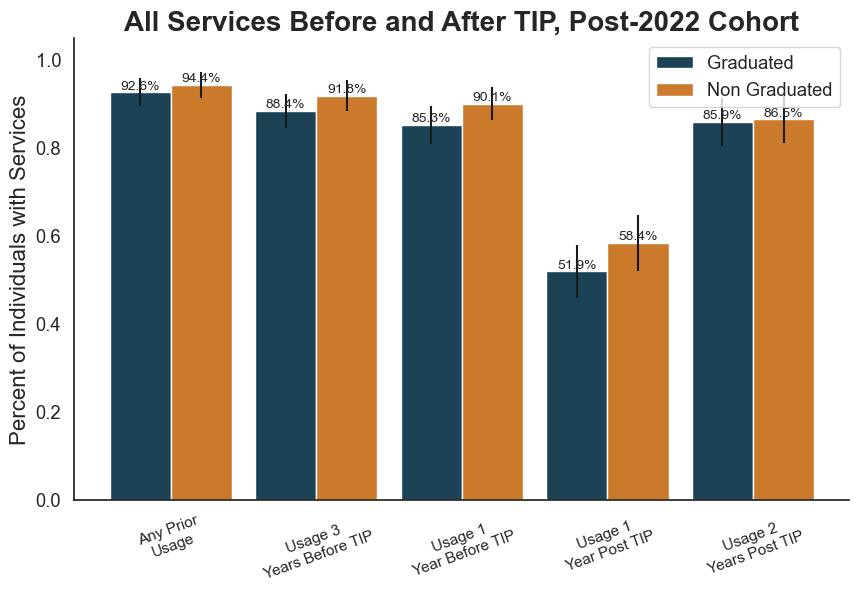

In [129]:
# ================
# CONFIG FOR COHORT 2
# ================

# keep only Graduated / Non Graduated
svc_c1 = df_services.copy()
svc_c1 = svc_c1[svc_c1["Status"].isin(["Graduated", "Non Graduated"])].copy()
svc_c1 = svc_c1[svc_c1["cohort_2022"] == 2].copy()

# -----------------------------
# 1) PRE cumulative bins
# -----------------------------

pre_bins = {
    -1: [-1],             # 1 year pre
    -3: [-3, -2, -1],     # 1-3 years pre
    -30: list(range(-30, 0))  # any prior usage
}

svc_c1["YearsSinceTIP_int"] = svc_c1["YearsSinceTIP"].round().astype(int)

rows = []
for bin_edge, years in pre_bins.items():
    cur = svc_c1[svc_c1["YearsSinceTIP_int"].isin(years)]
    
    row = {"YearsSinceTIP": bin_edge}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        row[status] = num
        
    rows.append(row)

pre_count = pd.DataFrame(rows)

# denominators for pre: total people per status

denom_pre = (
    df[(df["Status"].isin(["Graduated", "Non Graduated"])) & (df["cohort_2022"] == 2)]
    .groupby("Status")["tip_id"]
    .nunique()
    .to_dict()
)

z = 1.96
for status in ["Graduated", "Non Graduated"]:
    pre_count[f"{status} Percent"] = pre_count[status] / denom_pre.get(status, np.nan)
    p = pre_count[f"{status} Percent"]
    n = denom_pre.get(status, np.nan)
    se = np.sqrt(p * (1 - p) / n)
    pre_count[f"{status}_Upper_CI"] = (p + z * se).clip(0, 1)
    pre_count[f"{status}_Lower_CI"] = (p - z * se).clip(0, 1)

# -----------------------------
# 3) POST: cumulative windows [0, i) for i = 1,2 and require ValidYears > i
# -----------------------------
post_points = [1, 2]
rows = []

for i in post_points:
    cur = svc_c1[(svc_c1["YearsSinceTIP"] >= 0) & (svc_c1["YearsSinceTIP"] < i+1) & (svc_c1["ValidYears"] >= i)]

    row = {"YearsSinceTIP": i}
    for status in ["Graduated", "Non Graduated"]:
        num = cur.loc[cur["Status"] == status, "tip_id"].nunique()
        denom = df.loc[(df["Status"] == status) & (df["ValidYears"] >= i) & (df["cohort_2022"] == 2), "tip_id"].nunique()

        p = (num / denom) if denom > 0 else 0
        se = np.sqrt(p * (1 - p) / denom) if denom > 0 else np.nan

        row[f"{status}"] = num
        row[f"{status} Percent"] = p
        row[f"{status}_Upper_CI"] = min(1, p + z * se) if denom > 0 else np.nan
        row[f"{status}_Lower_CI"] = max(0, p - z * se) if denom > 0 else np.nan

    rows.append(row)

post_df = pd.DataFrame(rows)

# -----------------------------
# 4) assemble 6 categories + plot
# -----------------------------
label_map = {
    -30: "Any Prior\nUsage",
    -3:  "Usage 3\nYears Before TIP",
    -1:  "Usage 1\nYear Before TIP",
     1:  "Usage 1\nYear Post TIP",
     2:  "Usage 2\nYears Post TIP"
}
order = [-30, -3, -1, 1, 2]

pre_keep = pre_count[pre_count["YearsSinceTIP"].isin([-30, -3, -1])].copy()
data = pd.concat([pre_keep, post_df], ignore_index=True)

data["YearsSinceTIP"] = data["YearsSinceTIP"].astype(int)
data["YearsSinceTIP"] = pd.Categorical(data["YearsSinceTIP"], categories=order, ordered=True)
data = data.sort_values("YearsSinceTIP").reset_index(drop=True)
data["label"] = data["YearsSinceTIP"].astype(int).map(label_map)

grad_err = np.abs(
    data[["Graduated_Upper_CI", "Graduated_Lower_CI"]].T.values - data["Graduated Percent"].values
)
non_grad_err = np.abs(
    data[["Non Graduated_Upper_CI", "Non Graduated_Lower_CI"]].T.values - data["Non Graduated Percent"].values
)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(data))
width = 0.42

ax.bar(x - width/2, data["Graduated Percent"], width=width, label="Graduated", yerr=grad_err, capsize=0)
ax.bar(x + width/2, data["Non Graduated Percent"], width=width, label="Non Graduated", yerr=non_grad_err, capsize=0)

ax.set_xticks(x)
ax.set_xticklabels(data["label"], rotation=20, ha="center", fontsize=11)

for xi, yi in zip(x - width/2, data["Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)
for xi, yi in zip(x + width/2, data["Non Graduated Percent"]):
    ax.text(xi, yi, f"{yi:.1%}", ha="center", va="bottom", fontsize=10)

sns.despine()
plt.title("All Services Before and After TIP, Post-2022 Cohort", fontdict={"fontsize": 20, "fontweight": "semibold"})
plt.ylabel("Percent of Individuals with Services", fontdict={"fontsize": 16})
plt.ylim(0, 1.05)
plt.legend(loc="upper right")
plt.show()
